In [ ]:
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from scipy import sparse

import pickle
import random
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from google.colab import files
import time

# optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k

# Define our hyperparameter seearch space
def objective(trial):

    # Use LightFMs inbuilt train-test split function to create train and validation subsets
    train, val = random_train_test_split(sparse.csr_matrix(train_interactions.values), test_percentage=0.25, random_state=42)

    # Define the hyperparameter space
    param = {
        'no_components': trial.suggest_int("no_components", 5, 64),
        "learning_schedule": trial.suggest_categorical("learning_schedule", ["adagrad", "adadelta"]),
        "loss":  trial.suggest_categorical("loss", ["bpr", "warp", "warp-kos"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "item_alpha": trial.suggest_float("item_alpha", 1e-10, 1e-06, log=True),
        "user_alpha": trial.suggest_float("user_alpha", 1e-10, 1e-06, log=True),
        "max_sampled": trial.suggest_int("max_sampled", 5, 15),
    }
    epochs = trial.suggest_int("epochs", 20, 50)

    model = LightFM(**param, random_state=42)
    model.fit(train,
              epochs = epochs,
              verbose=True)

    val_precision = precision_at_k(model,
                                   val,
                                   train_interactions=train,
                                   k=10).mean()
    return val_precision

# Define the study
study = optuna.create_study(direction="maximize")



In [ ]:
# Add in our original hyperparmeter values as a starting point for Optuna
study.enqueue_trial(params={"no_components":10,
                            					"learning_schedule":'adagrad',
                            					"loss":'warp',
                            					"learning_rate":0.05,
                            					"item_alpha":1e-10,
                            					"user_alpha":1e-10,
                            					"max_sampled":10,
                            					"epochs":30})

# Run the optimisation
study.optimize(objective, n_trials=50)

# Save the best parameters
best_params = study.best_params
for k, v in best_params.items():
    print(k,":",v)

In [ ]:
# Which parameters were the most important?
optuna.importance.get_param_importances(study)

# Основной алгоритм



In [ ]:
# задачем название колонки в которой лежит вес пользователей для агрегации
INDIVIDUAL_COEF = 'final_coef'
# параметры модели
# если поставить в модели n_components > чем вторая размерность
# user_features (сейчас она 13), то групповой предикт не будет работать
# если поставить равный то будет работать
COMPONENTS = 10
IDENTITY = True

In [ ]:
# каталог мероприятий в сыром виде
event_data = pd.read_excel('events.xlsx')
# данные о пои, юзерах и трен взаимодействиях
train_event_features = pd.read_csv('encoded_items_train.csv')
test_event_features = pd.read_csv('encoded_items_test.csv')
user_features_data = pd.read_csv('user_traits.csv')
train_interactions = pd.read_csv('interactions_train.csv', index_col=0)


train_event_features = train_event_features.rename(columns={'id': 'item_id'})
train_event_features['item_id'] = train_event_features['item_id'].astype(str)
test_event_features = test_event_features.rename(columns={'id': 'item_id'})
test_event_features['item_id'] = test_event_features['item_id'].astype(str)
train_interactions.columns = train_interactions.columns.astype(str)
# делаем 1 из дизлайка и 5 из лайка
train_interactions = train_interactions.replace(1, 5).replace(-1, 1)


user_features_data = user_features_data.rename(columns={'name': 'user_id'})
user_features_data = user_features_data.drop(
    list(set([
        'mood',
        'Соперничество',
        'Сотрудничество',
        'Компромисс',
        'Избегание',
        'Приспособление',
        'conflict_coef',
        'Extraversion',
        'Agreableness',
        'Conscientiousness',
        'Neuroticism',
        'Openness',
        'character_coef',
        'final_coef',
        'final_coef_scaled',
    ]) - {INDIVIDUAL_COEF}),
    axis=1,
)

In [ ]:
user_features_data

,user_id,age,income,final_coef,residence_moscow,residence_nnovgorod,fulltime_work,student,unemployed
0,Окси,24,3,0.760000,1,0,1,0,0
1,Катя,23,1,1.216154,0,1,0,1,1
2,Ксю,23,3,0.603750,1,0,1,0,0
3,Лиза,22,2,1.014444,0,1,1,1,0
4,Ира,24,2,1.700000,0,1,1,1,0
5,Аня,23,2,1.666000,0,1,1,0,0


In [ ]:
scaler = MinMaxScaler()

user_features_data[['age', 'income']] = scaler.fit_transform(user_features_data[['age', 'income']])
user_features_data

,user_id,age,income,final_coef,residence_moscow,residence_nnovgorod,fulltime_work,student,unemployed
0,Окси,1.0,1.0,0.760000,1,0,1,0,0
1,Катя,0.5,0.0,1.216154,0,1,0,1,1
2,Ксю,0.5,1.0,0.603750,1,0,1,0,0
3,Лиза,0.0,0.5,1.014444,0,1,1,1,0
4,Ира,1.0,0.5,1.700000,0,1,1,1,0
5,Аня,0.5,0.5,1.666000,0,1,1,0,0


In [ ]:
user_features_data.loc[0, 'final_coef'] = 0.5
user_features_data.loc[1, 'final_coef'] = 1.229
user_features_data.loc[2, 'final_coef'] = 0.403
user_features_data.loc[3, 'final_coef'] = 0.733
user_features_data.loc[4, 'final_coef'] = 1.452
user_features_data.loc[5, 'final_coef'] = 1.232

'''
"0,403" ксю
"1,232" аня
"0,733" лиза
"1,229" катя
"1,452" ира
"0,500" окси
'''

'\n"0,403" ксю\n"1,232" аня\n"0,733" лиза\n"1,229" катя\n"1,452" ира\n"0,500" окси\n'

In [ ]:
dataset = Dataset(user_identity_features=IDENTITY, item_identity_features=IDENTITY)

dataset.fit(
    users=user_features_data['user_id'],
    # придется запихнуть все разом, потому что иначе не получится дообучить модель
    # она после добавление взаимодействий ругается что item фичи не совпадают в размере
    items=pd.concat([train_event_features, test_event_features], axis=0)['item_id'],
    user_features=user_features_data.drop(
        ['user_id', INDIVIDUAL_COEF], axis=1
        ).columns.tolist(),
    item_features=train_event_features.drop(
        ['item_id'], axis=1
    ).columns.tolist(),  # трейн потому что колонки одинаковые
)

In [ ]:
print(
    dataset.interactions_shape(),
    dataset.item_features_shape(),
    # dataset.mapping(),
    dataset.model_dimensions(),
    dataset.user_features_shape(),
)

(6, 202) (202, 250) (13, 250) (6, 13)


In [ ]:
user_features = dataset.build_user_features(
    (
        (x['user_id'], {f: x[f] for f in user_features_data.drop(INDIVIDUAL_COEF, axis=1).columns if f != 'user_id'})
        for _, x in user_features_data.drop(INDIVIDUAL_COEF, axis=1).iterrows()
    ), normalize=False
)


train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in train_event_features.columns if f != 'item_id'})
        for _, x in train_event_features.iterrows()
    ), normalize=False
)


# test_item_features = dataset.build_item_features(
#     (
#         (x['item_id'].astype(int)), {f: x[f] for f in test_event_features.columns if f != 'item_id'})
#     for _, x in test_event_features.iterrows()
# )

# создаем разреженную матрицу взаимодействий
interaction_matrix = sparse.csr_matrix(train_interactions.values)

In [ ]:
print(
    dataset.interactions_shape(),
    dataset.item_features_shape(),
    # dataset.mapping(),
    dataset.model_dimensions(),
    dataset.user_features_shape(),
)

(6, 202) (202, 250) (13, 250) (6, 13)


In [ ]:
model = LightFM(loss='warp',
                # learning_schedule='adagrad',
                no_components=COMPONENTS,
                # learning_rate=0.58,
                random_state=42)

model.fit(
    interactions=interaction_matrix,
    user_features=user_features,
    item_features=train_item_features,
    epochs=30,
    num_threads=1
)

# сохраняем текущую модель
with open('ind_pref_based_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
def get_user_profile(md, ds, user_id, ufm):
    user_internal_id = ds.mapping()[0][user_id]
    return md.get_user_representations(ufm)[1][user_internal_id]


# Агрегация профилей пользователей с учетом весов
def get_user_weight(user_row, col):
    # тут можно усложнить расчет весов
    return user_row[col]  # ** 2


def aggregate_user_profiles(md, ds, ufd, ufm, user_ids, user_weights, k=0):
    group_profile = np.zeros(md.get_user_representations(ufm)[1].shape[1])  # одномерный вектор размера n_components 10
    total_weight = 0
    for user_id in user_ids:
        user_idx = ufd.index[ufd['user_id'] == user_id].tolist()[0]
        user_profile = get_user_profile(md, ds, user_id, ufm)
        user_weight = get_user_weight(ufd.iloc[user_idx], user_weights)
        group_profile += user_profile * user_weight
        total_weight += user_weight

    if total_weight > 0:
      # аргумент k можно использовать для усиления влияния весов
        group_profile /= total_weight - total_weight * k

    return group_profile


# без весов
# def aggregate_user_profiles(md, ds, ufd, ufm, user_ids,):
#     group_profile = None
#     num_users = len(user_ids)

#     for user_id in user_ids:
#         user_profile = get_user_profile(md, ds, user_id, ufm)
#         if group_profile is None:
#             group_profile = np.zeros_like(user_profile)
#         group_profile += user_profile

#     group_profile /= num_users
#     return group_profile


def get_group_recommendations(md, ds, gp, test_item_features, test_events, ufm, n=20):
    _, _, item_mapping, _ = ds.mapping()
    internal_item_ids = [item_mapping[item_id] for item_id in test_events['item_id']]
    group_features = sparse.csr_matrix(gp.reshape(1, -1))
    scores = md.predict(
        user_ids=np.zeros(
            len(internal_item_ids), dtype=np.int32
        ),  # нули так как в гп у нас только 1 пользователь, его индекс 0
        # вообще тут должны быть внутренние id пользователей которым рекомендовать
        item_ids=np.array(internal_item_ids),  # из чего рекомендуем
        user_features=group_features,
        item_features=test_item_features,
    )
    top_items_indices = np.argsort(-scores)[:n]
    top_n_scores = sorted(scores.tolist(), reverse=True)[:n]
    # print(top_n_scores)
    return test_events.iloc[top_items_indices]['item_id'].tolist()

По поводу user_ids - в документашке написано вот это
**user_ids** (integer or np.int32 array of shape [n_pairs,]) – single user id or an array containing the user ids for the user-item pairs for which a prediction is to be computed. <u>Note that these are LightFM’s internal id’s, i.e. the index of the user in the interaction matrix used for fitting the model.</u> - не понятно что это за хрень, потому что в моем случае явно индексация задается относительно количества заданных user_features. если там три вектора, то дает использовать индексы 0, 1, 2, если один как у меня то дает только ноль и тд. и это явно не внутренний индекс, потому что почему?

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    model, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )

test_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in test_event_features.columns if f != 'item_id'})
        for _, x in test_event_features.iterrows()
    ),
    normalize=False,
)

top_n_group_recommendations = get_group_recommendations(
    model, dataset, group_profile, test_item_features, test_event_features, user_features
)

print(top_n_group_recommendations)

event_data['id'] = event_data['id'].astype(str)
# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:3])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:3])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(43)
event_data[
    event_data.id
    == random.choice(test_event_features[
        ~test_event_features.item_id.isin(top_n_group_recommendations[:3])
        ].item_id)
]

['136', '119', '125', '128', '122', '152', '129', '156', '1', '109', '86', '157', '144', '132', '104', '53', '105', '108', '74', '28']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,136,Фестиваль,"Животные, Спорт, Образовательное, Уличная",Открытие летнего сезона Центра национальных ко...,В программе: Фестиваль выходного дня иммерсив...,Даты: 28 апреля с 15:00,"Место: ВДНХ, Выводной круг",Стоимость: Вход свободный,Ссылка: Расписание ЗДЕСЬ
1,119,"Фестиваль, Концерт, Погулять","Песни, Природа, Спорт, Уличная",Фестиваль «Запуск лета: парк в ритме поп-рока»,"В программе: Ходулисты, Танцевальная тренировк...",Даты: 1 мая с 12:00 до 21:00,"Место: Парк Сокольники, Сад астрономов",Стоимость: Вход свободный,Ссылка: ЗДЕСЬ
2,125,"Погулять, Экскурсия","Уличная, Природа, Животные, История","Экотропы. «Там, на неведомых дорожках» в парке...",Во время экскурсии можно будет познакомиться с...,Даты: -,"Место: 55.693378, 37.788162 (дальше)",Стоимость: бесплатно,Ссылка: ссылка


,id,cat_1,cat_2,name,desc,date,loc,price,link
10,11,Выставка,"Современное Искусство, Арт-Объекты",Тупик,"Музей ART4 тестирует новый выставочный формат,...",Даты: по 30 апреля.,"Место: Москва, Хлыновский тупик, 4. галерея AR...",Стоимость: 300 ₽.,Ссылка: https://www.art4.ru/show/


#### 1

In [ ]:
# открываем модель
with open('ind_pref_based_model.pkl', 'rb') as mfile:
    loaded_model = pickle.load(mfile)

In [ ]:
NEW_ID_SET = ['119', '136', '125', '11']  # !!!!!
new1_interactions = pd.read_excel('intrc_it_11.xlsx', index_col=0)

new1_interactions.columns = new1_interactions.columns.astype(str)
new1_interactions = new1_interactions.dropna(axis=1, how='all')
new1_interactions = new1_interactions.fillna(0).replace(1, 5).replace(-1, 1)


# new1_interactions = new1_interactions.rename(columns={'136': '30', '122': '1'})  # !!!!!
new1_interactions = pd.concat([train_interactions, new1_interactions], axis=1).astype(int)
extended_interactions = sparse.csr_matrix(new1_interactions.values)

test_event_features['item_id'] = test_event_features['item_id'].astype(str)
new_event_features = test_event_features[test_event_features.item_id.isin(NEW_ID_SET)]

In [ ]:
new_train_event_features = pd.concat([train_event_features, test_event_features[test_event_features.item_id.isin(NEW_ID_SET)]])
new_train_event_features.shape

(130, 49)

In [ ]:
# объединенные
new_train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in new_train_event_features.columns if f != 'item_id'})
        for _, x in new_train_event_features.iterrows()
    ), normalize=False
)

In [ ]:
model.get_user_representations()[1][0]

array([ 0.2181788 ,  0.8072018 ,  0.2603314 ,  0.58339864, -0.48191088,
        0.35072967,  0.02179444, -0.3625396 ,  0.44975814, -0.34391952],
      dtype=float32)

In [ ]:
loaded_model.get_user_representations()[1][0]

array([ 0.2181788 ,  0.8072018 ,  0.2603314 ,  0.58339864, -0.48191088,
        0.35072967,  0.02179444, -0.3625396 ,  0.44975814, -0.34391952],
      dtype=float32)

In [ ]:
# 6442
new_train_item_features

<202x250 sparse matrix of type '<class 'numpy.float32'>'
	with 6442 stored elements in Compressed Sparse Row format>

In [ ]:
loaded_model.fit_partial(
    interactions=extended_interactions,
    user_features=user_features,
    item_features=new_train_item_features,
    epochs=2,
    num_threads=1
)


with open('1_group_based_model.pkl', 'wb') as model_file:
    pickle.dump(loaded_model, model_file)

In [ ]:
model.get_user_representations()[1][0]

array([ 0.2181788 ,  0.8072018 ,  0.2603314 ,  0.58339864, -0.48191088,
        0.35072967,  0.02179444, -0.3625396 ,  0.44975814, -0.34391952],
      dtype=float32)

In [ ]:
loaded_model.get_user_representations()[1][0]

array([ 0.23177938,  0.826033  ,  0.24668643,  0.5851484 , -0.4648882 ,
        0.32600564,  0.0133052 , -0.37680596,  0.43859562, -0.33166203],
      dtype=float32)

In [ ]:
group_profile

array([ 0.70969974,  0.61902721,  0.34749353,  0.15225272, -0.28138178,
       -0.65438222, -0.44678384, -0.37111455, -0.52797591, -0.35301139])

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    loaded_model, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )
group_profile

array([ 0.75279605,  0.67136485,  0.36458179,  0.09540245, -0.19218179,
       -0.7674408 , -0.46970268, -0.3317718 , -0.62388041, -0.25919138])

In [ ]:
# 72
test_event_features_cut = test_event_features.drop(
    test_event_features[
        test_event_features.item_id.isin(NEW_ID_SET)
        ].index, axis=0
    )
test_event_features_cut.shape

(72, 49)

In [ ]:
CHOOSE_FROM = test_event_features_cut.copy(deep=True)
CHOOSE_FROM_FTRS= test_item_features

top_n_group_recommendations = get_group_recommendations(
    loaded_model, dataset, group_profile,
    CHOOSE_FROM_FTRS, CHOOSE_FROM, user_features
)
print(top_n_group_recommendations)

# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:3])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:3])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(83)
event_data[
    event_data.id
    == random.choice(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations[:3])].item_id.values)
]

['152', '21', '122', '156', '109', '86', '128', '105', '104', '157', '129', '18', '1', '74', '108', '53', '28', '30', '144', '3']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,152,Выставка,"Мультфильмы, Мультимедиа",Постоянная экспозиция мультимедийного центра «...,Мультимедийный развлекательно-развивающий цент...,Даты: Ежедневно 10:00 — 21:00,"Место: ВДНХ, Павильон №7",Стоимость: 550 - 1500р,Ссылка: https://vdnh.ru/events/ekspozitsiya-mu...
1,21,"Выставка, Погулять","Растения, Природа",Тюльпаны и другие весенние цветы распустились ...,С 19 марта в Субтропической оранжерее Ботаниче...,Даты: 19 марта - 15 мая,"Место: Москва, Проспект Мира, 26/1 (город)","Стоимость: от 200 рублей, дети до 7 лет и мно...",Ссылка: Подробнее
2,122,Погулять,"Природа, Животные",Идём кататься на конном экипаже в Центр воспро...,Катание для детей и взрослых осуществляется по...,"Даты: С 1 мая, ежедневно с 10:00 до 16:15","Место: Филиал Московского зоопарка в Сычево, В...",Стоимость: от 300р,Ссылка: -


,id,cat_1,cat_2,name,desc,date,loc,price,link
171,173,"Кинопоказ, Лекция","Кино, Личности, Классика",Киноклуб в Антипе «Крупная рыба»,"Фильм Тима Бертона, который слегка отличается ...","Даты: 27 ноября, 20:00","Место: Дом Антипа (Малый Знаменский переулок, 9)",Стоимость: бесплатно,Ссылка: -


#### 2

In [ ]:
NEW_ID_SET2 = ['152', '21', '122', '173']  # !!!!!
# открываем модель
with open('1_group_based_model.pkl', 'rb') as mfile:
    loaded_model2 = pickle.load(mfile)

new2_interactions = pd.read_excel('intrc_it_22.xlsx', index_col=0)

In [ ]:
new2_interactions.columns = new2_interactions.columns.astype(str)
new2_interactions = new2_interactions.dropna(axis=1, how='all')
new2_interactions = new2_interactions.fillna(0).replace(1, 5).replace(-1, 1)

new2_interactions = pd.concat([new1_interactions, new2_interactions], axis=1).astype(int)
extended_interactions = sparse.csr_matrix(new2_interactions.values)

new2_event_features = test_event_features[test_event_features.item_id.isin(NEW_ID_SET2)]

In [ ]:
new2_interactions.shape

(6, 134)

In [ ]:
extended_interactions

<6x134 sparse matrix of type '<class 'numpy.int64'>'
	with 485 stored elements in Compressed Sparse Row format>

In [ ]:
new_train_event_features = pd.concat([train_event_features, new_event_features, new2_event_features])
new_train_event_features.shape

(134, 49)

In [ ]:
# объединенные
new_train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in new_train_event_features.columns if f != 'item_id'})
        for _, x in new_train_event_features.iterrows()
    ), normalize=False
)

In [ ]:
new_train_item_features

<202x250 sparse matrix of type '<class 'numpy.float32'>'
	with 6634 stored elements in Compressed Sparse Row format>

In [ ]:
loaded_model.get_user_representations()[1][0]

array([ 0.23177938,  0.826033  ,  0.24668643,  0.5851484 , -0.4648882 ,
        0.32600564,  0.0133052 , -0.37680596,  0.43859562, -0.33166203],
      dtype=float32)

In [ ]:
loaded_model2.get_user_representations()[1][0]

array([ 0.23177938,  0.826033  ,  0.24668643,  0.5851484 , -0.4648882 ,
        0.32600564,  0.0133052 , -0.37680596,  0.43859562, -0.33166203],
      dtype=float32)

In [ ]:
loaded_model2.fit_partial(
    interactions=extended_interactions,
    user_features=user_features,
    item_features=new_train_item_features,
    epochs=2,
    num_threads=1
)

with open('2_group_based_model.pkl', 'wb') as model_file:
    pickle.dump(loaded_model2, model_file)

In [ ]:
loaded_model.get_user_representations()[1][0]

array([ 0.23177938,  0.826033  ,  0.24668643,  0.5851484 , -0.4648882 ,
        0.32600564,  0.0133052 , -0.37680596,  0.43859562, -0.33166203],
      dtype=float32)

In [ ]:
loaded_model2.get_user_representations()[1][0]

array([ 0.23869179,  0.86466223,  0.24834852,  0.5931383 , -0.47686478,
        0.32100725,  0.0161411 , -0.38641727,  0.45931667, -0.32934105],
      dtype=float32)

In [ ]:
group_profile

array([ 0.75279605,  0.67136485,  0.36458179,  0.09540245, -0.19218179,
       -0.7674408 , -0.46970268, -0.3317718 , -0.62388041, -0.25919138])

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    loaded_model2, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )
group_profile

array([ 0.80592228,  0.8592267 ,  0.38166762, -0.01135793, -0.21444262,
       -0.87126472, -0.56631003, -0.28566585, -0.65052415, -0.20909916])

In [ ]:
# 68
test_event_features_cut = test_event_features.drop(test_event_features[
    test_event_features.item_id.isin(NEW_ID_SET + NEW_ID_SET2)
    ].index, axis=0)
test_event_features_cut.shape

(68, 49)

In [ ]:
test_item_features

<202x250 sparse matrix of type '<class 'numpy.float32'>'
	with 3850 stored elements in Compressed Sparse Row format>

In [ ]:
CHOOSE_FROM = test_event_features_cut.copy(deep=True)  # обрезанный потому что нельзя рекомендовать лайкнутые
CHOOSE_FROM_FTRS = test_item_features # не обрезанный потому что зачем, у медели и так есть все фичи тестовых пои

top_n_group_recommendations = get_group_recommendations(
    loaded_model2, dataset, group_profile,
    CHOOSE_FROM_FTRS, CHOOSE_FROM, user_features
)
print(top_n_group_recommendations)

# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:3])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:3])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(83)
event_data[
    event_data.id
    == random.choice(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations[:3])].item_id.values)
]

['86', '53', '18', '105', '157', '156', '104', '129', '74', '132', '118', '1', '28', '68', '109', '3', '128', '108', '32', '197']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,86,Выставка,"Мультимедиа, Современное Искусство",Первое в мире уникальное иммерсивное шоу,В столице есть первое иммерсивное арт-простран...,Даты: Пн-Вс 10:00-22:00,"Место: Москва, 2-я Останкинская ул., 3 (город)",Стоимость: 1500 ₽,Ссылка: Купить билет
1,53,"Фестиваль, Кинопоказ","Еда, Кино, Классика",До 12 мая в Москве идет фестиваль «Ешь! Смотри...,Уже третий по счету фестиваль собрал более 50 ...,Даты: до 12 мая,Место: в ресторанах,Стоимость: от 2000 р,Ссылка: ссылка
2,18,Кинопоказ,"Мультфильмы, Классика",В мае в сети кинотеатров Москино продолжат пок...,С 5 по 19 мая на большие экраны кинотеатров Мо...,Даты: по 19 мая.,Место: Кинотеатры Москино,"Стоимость: Бесплатно, по предварительной регис...",Ссылка: Подробнее


,id,cat_1,cat_2,name,desc,date,loc,price,link
195,197,Мастерклассы,Живопись,Мастер-класс по зарисовкам с натуры в особняке...,Пока проект мастер-классов Your Hidden Talent ...,"Даты: 05.05, с 18:30-20:30","Место: Новая Басманная, 19с1",Стоимость: 4500р,Ссылка: Забронировать тут (количество мест 15)


#### 3

In [ ]:
NEW_ID_SET3 = ['86', '53', '18', '197']  # !!!!!
# открываем модель
with open('2_group_based_model.pkl', 'rb') as mfile:
    loaded_model3 = pickle.load(mfile)

new3_interactions = pd.read_excel('intrc_it_33.xlsx', index_col=0)

In [ ]:
new3_interactions.columns = new3_interactions.columns.astype(str)
new3_interactions = new3_interactions.dropna(axis=1, how='all')
new3_interactions = new3_interactions.fillna(0).replace(1, 5).replace(-1, 1)

new3_interactions = pd.concat([new2_interactions, new3_interactions], axis=1).astype(int)
extended_interactions = sparse.csr_matrix(new3_interactions.values)

new3_event_features = test_event_features[test_event_features.item_id.isin(NEW_ID_SET3)]

In [ ]:
extended_interactions

<6x138 sparse matrix of type '<class 'numpy.int64'>'
	with 509 stored elements in Compressed Sparse Row format>

In [ ]:
new_train_event_features = pd.concat([train_event_features, new_event_features, new2_event_features, new3_event_features])
new_train_event_features.shape

(138, 49)

In [ ]:
# объединенные
new_train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in new_train_event_features.columns if f != 'item_id'})
        for _, x in new_train_event_features.iterrows()
    ), normalize=False
)

In [ ]:
# > 6600
new_train_item_features

<202x250 sparse matrix of type '<class 'numpy.float32'>'
	with 6826 stored elements in Compressed Sparse Row format>

In [ ]:
loaded_model2.get_user_representations()[1][0]

array([ 0.23869179,  0.86466223,  0.24834852,  0.5931383 , -0.47686478,
        0.32100725,  0.0161411 , -0.38641727,  0.45931667, -0.32934105],
      dtype=float32)

In [ ]:
loaded_model3.get_user_representations()[1][0]

array([ 0.23869179,  0.86466223,  0.24834852,  0.5931383 , -0.47686478,
        0.32100725,  0.0161411 , -0.38641727,  0.45931667, -0.32934105],
      dtype=float32)

In [ ]:
loaded_model3.fit_partial(
    interactions=extended_interactions,
    user_features=user_features,
    item_features=new_train_item_features,
    epochs=2,
    num_threads=1
)

with open('3_group_based_model.pkl', 'wb') as model_file:
    pickle.dump(loaded_model3, model_file)

In [ ]:
loaded_model2.get_user_representations()[1][0]

array([ 0.23869179,  0.86466223,  0.24834852,  0.5931383 , -0.47686478,
        0.32100725,  0.0161411 , -0.38641727,  0.45931667, -0.32934105],
      dtype=float32)

In [ ]:
loaded_model3.get_user_representations()[1][0]

array([ 0.2581437 ,  0.90340567,  0.24035932,  0.5950132 , -0.4744262 ,
        0.32149488,  0.01025697, -0.38986224,  0.47255412, -0.33433077],
      dtype=float32)

In [ ]:
group_profile

array([ 0.80592228,  0.8592267 ,  0.38166762, -0.01135793, -0.21444262,
       -0.87126472, -0.56631003, -0.28566585, -0.65052415, -0.20909916])

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    loaded_model3, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )
group_profile

array([ 0.85346849,  1.0058726 ,  0.38715098, -0.06981665, -0.2153884 ,
       -0.91773589, -0.54581106, -0.26520915, -0.63663045, -0.16610254])

In [ ]:
# 64
test_event_features_cut = test_event_features.drop(test_event_features[
    test_event_features.item_id.isin(NEW_ID_SET + NEW_ID_SET2 + NEW_ID_SET3)
    ].index, axis=0)
test_event_features_cut.shape

(64, 49)

In [ ]:
CHOOSE_FROM = test_event_features_cut.copy(deep=True)  # обрезанный потому что нельзя рекомендовать лайкнутые
CHOOSE_FROM_FTRS = test_item_features # не обрезанный потому что зачем, у медели и так есть все фичи тестовых пои

top_n_group_recommendations = get_group_recommendations(
    loaded_model3, dataset, group_profile,
    CHOOSE_FROM_FTRS, CHOOSE_FROM, user_features
)
print(top_n_group_recommendations)

# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:3])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:3])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(99)
event_data[
    event_data.id
    == random.choice(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations[:3])].item_id.values)
]

['28', '157', '68', '1', '132', '156', '74', '129', '104', '30', '114', '3', '108', '109', '179', '128', '168', '78', '155', '144']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,28,Выставка,"Мультимедиа, Современное Искусство","ЦСИ М’АРС, контентная платформа Дзен и арт-гру...","Проект посвящён алгоритмам и технологиям, кото...",Даты: каждый день с 12:00 до 22:00 до 31 мая,"Место: Москва, Пушкарёв пер., 5, ЦСИ М’АРС (го...",Стоимость: 600р,Ссылка: Билеты
1,157,Кинопоказ,"Кино, Новое, Личности","СОФИ ЛОРЕН. ЖИТЬ, СНИМАТЬСЯ, ЛЮБИТЬ!",Юбилейный Russia-Italia Film Festival (RIFF) ...,"Даты: 11 мая, 16:00",Место: КАРО 11 Октябрь,Стоимость: 500р,Ссылка: https://2023.riff-russia.ru/filmy/451-...
2,68,Перформанс,"Танцы, Современное Искусство",Перформанс «Пустое пространство»,Действие - загадка. Представление - тайна. Даж...,"Даты: 12 мая, 19:00-20:00","Место: Москва, улица Сайкина, 9, строение 1 (г...",Стоимость: 1500р,Ссылка: ссылка


,id,cat_1,cat_2,name,desc,date,loc,price,link
77,78,Выставка,"Мультимедиа, Живопись, Современное Искусство","Матисс, Пикассо или Ван Гог?",Выбирать не нужно — в Artplay Media сейчас про...,Даты: Пн–Вс: 08:00-23:00 до 19 мая,"Место: Москва, ул. Нижняя Сыромятническая, д. ...",Стоимость: 800 ₽,Ссылка: Купить билет


#### 4

In [ ]:
NEW_ID_SET4 = ['28', '157', '78', '68']   # !!!!!
# открываем модель
with open('3_group_based_model.pkl', 'rb') as mfile:
    loaded_model4 = pickle.load(mfile)

new4_interactions = pd.read_excel('intrc_it_44.xlsx', index_col=0)

In [ ]:
new4_interactions.columns = new4_interactions.columns.astype(str)
new4_interactions = new4_interactions.dropna(axis=1, how='all')
new4_interactions = new4_interactions.fillna(0).replace(1, 5).replace(-1, 1)

new4_interactions = pd.concat([new3_interactions, new4_interactions], axis=1).astype(int)
extended_interactions = sparse.csr_matrix(new4_interactions.values)

new4_event_features = test_event_features[test_event_features.item_id.isin(NEW_ID_SET4)]

In [ ]:
extended_interactions

<6x142 sparse matrix of type '<class 'numpy.int64'>'
	with 533 stored elements in Compressed Sparse Row format>

In [ ]:
# 142
new_train_event_features = pd.concat(
    [train_event_features, new_event_features,
     new2_event_features, new3_event_features,
     new4_event_features]
)
new_train_event_features.shape

(142, 49)

In [ ]:
# объединенные
new_train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in new_train_event_features.columns if f != 'item_id'})
        for _, x in new_train_event_features.iterrows()
    ), normalize=False
)

In [ ]:
#  > 6800
new_train_item_features

<202x250 sparse matrix of type '<class 'numpy.float32'>'
	with 7018 stored elements in Compressed Sparse Row format>

In [ ]:
loaded_model3.get_user_representations()[1][0]

array([ 0.2581437 ,  0.90340567,  0.24035932,  0.5950132 , -0.4744262 ,
        0.32149488,  0.01025697, -0.38986224,  0.47255412, -0.33433077],
      dtype=float32)

In [ ]:
loaded_model4.get_user_representations()[1][0]

array([ 0.2581437 ,  0.90340567,  0.24035932,  0.5950132 , -0.4744262 ,
        0.32149488,  0.01025697, -0.38986224,  0.47255412, -0.33433077],
      dtype=float32)

In [ ]:
loaded_model4.fit_partial(
    interactions=extended_interactions,
    user_features=user_features,  # добавить настроение
    item_features=new_train_item_features,
    epochs=2,
    num_threads=1
)

with open('4_group_based_model.pkl', 'wb') as model_file:
    pickle.dump(loaded_model4, model_file)

In [ ]:
loaded_model3.get_user_representations()[1][0]

array([ 0.2581437 ,  0.90340567,  0.24035932,  0.5950132 , -0.4744262 ,
        0.32149488,  0.01025697, -0.38986224,  0.47255412, -0.33433077],
      dtype=float32)

In [ ]:
loaded_model4.get_user_representations()[1][0]

array([ 0.2743888 ,  0.9404862 ,  0.25988168,  0.61312914, -0.47924015,
        0.32066885,  0.02882016, -0.3915559 ,  0.48154452, -0.31307763],
      dtype=float32)

In [ ]:
group_profile

array([ 0.85346849,  1.0058726 ,  0.38715098, -0.06981665, -0.2153884 ,
       -0.91773589, -0.54581106, -0.26520915, -0.63663045, -0.16610254])

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    loaded_model4, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )
group_profile

array([ 0.966086  ,  1.132978  ,  0.47034423, -0.16546198, -0.18529098,
       -0.99998905, -0.54016543, -0.17224235, -0.69029031, -0.08738241])

In [ ]:
# 60
test_event_features_cut = test_event_features.drop(test_event_features[
    test_event_features.item_id.isin(NEW_ID_SET + NEW_ID_SET2 + NEW_ID_SET3 + NEW_ID_SET4)
    ].index, axis=0)
test_event_features_cut.shape

(60, 49)

In [ ]:
CHOOSE_FROM = test_event_features_cut.copy(deep=True)  # обрезанный потому что нельзя рекомендовать лайкнутые
CHOOSE_FROM_FTRS = test_item_features # не обрезанный потому что зачем, у медели и так есть все фичи тестовых пои

top_n_group_recommendations = get_group_recommendations(
    loaded_model4, dataset, group_profile,
    CHOOSE_FROM_FTRS, CHOOSE_FROM, user_features
)
print(top_n_group_recommendations)

# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:3])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:3])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(58)
event_data[
    event_data.id
    == random.choice(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations[:3])].item_id.values)
]

['156', '1', '132', '3', '74', '129', '30', '114', '155', '109', '32', '179', '128', '108', '104', '69', '61', '118', '188', '105']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,156,Кинопоказ,"Кино, Новое, Личности",ДАНТЕ. ВЕЧНОСТЬ ГЕНИЯ,В рамках 10 юбилейного Russia-Italia Film Fest...,"Даты: 10 мая, 12:00",Место: КАРО 11 Октябрь,Стоимость: 500р,Ссылка: https://2023.riff-russia.ru/filmy/455-...
1,1,Выставка,"Спорт, Современное Искусство, Мультимедиа",ТЕОРЕМА ДОЖДЯ,"Мультимедиа Арт Музей, Москва представляет инс...",Даты: с 13 апреля по 15 июля.,"Место: Москва, ул. Остоженка, 16. МАММ. (город)","Стоимость: студенты 350, взрослые 700 ₽. Билет...",Ссылка: https://mamm-mdf.ru
2,132,Погулять,"Еда, Животные, Развлечения",Зайкафе,"Можно поиграть с кроликами, покормить их, сфот...",Даты: Ежедневно 10:00-22:00,Место: Ул. Селезневская 4,Стоимость: 400₽ + 12₽/мин,Ссылка: -


,id,cat_1,cat_2,name,desc,date,loc,price,link
117,118,Экскурсия,"Уличная, История",Идем на пешеходную экскурсию по Крутицкому под...,Вы узнаете много интересного о чудом сохранивш...,Даты: 4 мая в 13:00,"Место: М. Пролетарская, выход 9",Стоимость: Сумма благодарности на ваше усмотре...,Ссылка: ЗДЕСЬ


In [ ]:
# random seed для рандома рекомендации

# for i in range(0, 1000):
#   random.seed(i)
#   if random.choice(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations[:3])].item_id.values) == '118':
#     print(i)

#### 5

In [ ]:
NEW_ID_SET5 = ['156', '1', '132', '118']   # !!!!!
# открываем модель
with open('4_group_based_model.pkl', 'rb') as mfile:
    loaded_model5 = pickle.load(mfile)

new5_interactions = pd.read_excel('intrc_it_55.xlsx', index_col=0)

In [ ]:
new5_interactions.columns = new5_interactions.columns.astype(str)
new5_interactions = new5_interactions.dropna(axis=1, how='all')
new5_interactions = new5_interactions.fillna(0).replace(1, 5).replace(-1, 1)

new5_interactions = pd.concat([new4_interactions, new5_interactions], axis=1).astype(int)
extended_interactions = sparse.csr_matrix(new5_interactions.values)

new5_event_features = test_event_features[test_event_features.item_id.isin(NEW_ID_SET5)]

In [ ]:
extended_interactions

<6x146 sparse matrix of type '<class 'numpy.int64'>'
	with 557 stored elements in Compressed Sparse Row format>

In [ ]:
# 146
new_train_event_features = pd.concat([train_event_features, new_event_features,
                                      new2_event_features, new3_event_features,
                                      new4_event_features, new5_event_features])
new_train_event_features.shape

(146, 49)

In [ ]:
# объединенные
new_train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in new_train_event_features.columns if f != 'item_id'})
        for _, x in new_train_event_features.iterrows()
    ), normalize=False
)

In [ ]:
# > 6900
new_train_item_features

<202x250 sparse matrix of type '<class 'numpy.float32'>'
	with 7210 stored elements in Compressed Sparse Row format>

In [ ]:
loaded_model4.get_user_representations()[1][0]

array([ 0.2743888 ,  0.9404862 ,  0.25988168,  0.61312914, -0.47924015,
        0.32066885,  0.02882016, -0.3915559 ,  0.48154452, -0.31307763],
      dtype=float32)

In [ ]:
loaded_model5.get_user_representations()[1][0]

array([ 0.2743888 ,  0.9404862 ,  0.25988168,  0.61312914, -0.47924015,
        0.32066885,  0.02882016, -0.3915559 ,  0.48154452, -0.31307763],
      dtype=float32)

In [ ]:
loaded_model5.fit_partial(
    interactions=extended_interactions,
    user_features=user_features,  # добавить настроение
    item_features=new_train_item_features,
    epochs=2,
    num_threads=1
)

with open('5_group_based_model.pkl', 'wb') as model_file:
    pickle.dump(loaded_model5, model_file)

In [ ]:
loaded_model4.get_user_representations()[1][0]

array([ 0.2743888 ,  0.9404862 ,  0.25988168,  0.61312914, -0.47924015,
        0.32066885,  0.02882016, -0.3915559 ,  0.48154452, -0.31307763],
      dtype=float32)

In [ ]:
loaded_model5.get_user_representations()[1][0]

array([ 0.28102955,  0.9770922 ,  0.27628675,  0.6325903 , -0.46577045,
        0.3325434 ,  0.02666536, -0.37963846,  0.48852897, -0.29540893],
      dtype=float32)

In [ ]:
group_profile

array([ 0.966086  ,  1.132978  ,  0.47034423, -0.16546198, -0.18529098,
       -0.99998905, -0.54016543, -0.17224235, -0.69029031, -0.08738241])

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    loaded_model5, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )
group_profile

array([ 1.03585137,  1.24655474,  0.51431048, -0.26944175, -0.14851121,
       -1.08155039, -0.55397536, -0.0970817 , -0.72139221,  0.00644614])

In [ ]:
# 56
test_event_features_cut = test_event_features.drop(test_event_features[
    test_event_features.item_id.isin(NEW_ID_SET + NEW_ID_SET2 + NEW_ID_SET3 + \
                                     NEW_ID_SET4 + NEW_ID_SET5)
    ].index, axis=0)
test_event_features_cut.shape

(56, 49)

In [ ]:
CHOOSE_FROM = test_event_features_cut.copy(deep=True)  # обрезанный потому что нельзя рекомендовать лайкнутые
CHOOSE_FROM_FTRS = test_item_features # не обрезанный потому что зачем, у медели и так есть все фичи тестовых пои

top_n_group_recommendations = get_group_recommendations(
    loaded_model5, dataset, group_profile,
    CHOOSE_FROM_FTRS, CHOOSE_FROM, user_features
)
print(top_n_group_recommendations)

# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations)]
    .set_index('id')
    .reindex(top_n_group_recommendations)
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(1098)
event_data[
    event_data.id.isin(random.choices(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations)].item_id.values, k=15))
]

['129', '3', '109', '108', '30', '104', '128', '51', '114', '69', '105', '155', '61', '32', '179', '35', '44', '42', '99', '74']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,129,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Захарьинская пойма» в заказнике «До...,Ландшафтный заказник «Долина реки Сходни в Кур...,Даты: -,"Место: 55.907730, 37.386544 (далеко)",Стоимость: бесплатно,Ссылка: -
1,3,Выставка,"Фотография, История",Алфавит. Советская фотография 1920-1930-х годов,Фундаментальное исследование одного из ярчайши...,Даты: по 26 мая.,"Место: Москва, Якиманская набережная., 2/1. Це...",Стоимость: 300-500 ₽. Билеты по ссылке.,Ссылка: https://betoncvc.com/exhibitions/alfav...
2,109,Выставка,"Фотография, Мода, История",Модницы XIX — начала ХХ века. Из коллекции МАММ,"Мультимедиа Арт Музей, Москва представляет выс...",Даты: до 15 июля,"Место: Москва, ул. Остоженка, 16. МАММ. (город)",Стоимость: бесплатно,Ссылка: ссылка
3,108,Выставка,"Фотография, Современное Искусство","О всех вещах, там обитающих",Выставка соберёт более 50 работ впервые показа...,Даты: до 26 мая,"Место: Stella Art Foundation, 1-й Красногварде...",Стоимость: бесплатно,Ссылка: ссылка
4,30,"Маркет, Лекция","Образовательное, Мода",Винтаж в особняке Леман: на выходных на Патриа...,Особняк Леман превратится в рай для любителей ...,Даты: 28 апреля с 11:00 до 21:00.,"Место: Москва, Гранатный пер., 7ст1.(город)",Стоимость: 400 рублей,Ссылка: Подробнее
5,104,Погулять,"Природа, Растения","6 мест в Москве, где зацветёт сакура",Сакура зацветет уже в мае! Её цветение продлит...,Даты: 1 - 31 мая,"Место: Москва, Дольская улица, 1с4, Москва (да...",Стоимость: бесплатно,Ссылка: -
6,128,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Природа Алешкинского леса» в Тушинс...,Экскурсия пройдет в Алешкинском лесу на террит...,Даты: -,"Место: 55.864036, 37.418725 (дальше)",Стоимость: бесплатно,Ссылка: ссылка
7,51,Кинопоказ,"Личности, Редкое",Кинопоказ «По Фрейду»,В Новой Третьяковке — показ байопика одного из...,"Даты: 28 апреля, 14:00","Место: Москва, ул. Крымский Вал, 10, Новая Тре...",Стоимость: 500р,Ссылка: билеты
8,114,Концерт,Инструменты,Концерт Дудук с оркестром,"Шедевры классической музыки, всемирно известны...",Даты: 4 мая 19:00,"Место: ул. Мельникова, 7, стр. 1","Стоимость: от 1400р, -25% по промокоду STAGE",Ссылка: Билеты по ссылке здесь
9,69,Спектакль,Новое,Спектакль «Комната №7» в особняке «Едва знакомы»,В историческом особняке на Третьяковской покаж...,Даты: 27-28 мая 19:30,"Место: Москва, Старомонетный пер. 22с2, Особня...",Стоимость: 2000р,Ссылка: ссылка


,id,cat_1,cat_2,name,desc,date,loc,price,link
14,15,Выставка,"Живопись, Культуры, История",Орлов. Котлован,Молодой художник и выпускник петербургской худ...,Даты: по 12 мая.,"Место: Москва, бульвар Гоголевский, 10/2. ММОМ...",Стоимость: 0-350 ₽. Билеты по ссылке.,Ссылка: https://mmoma.ru/visit/gallery/orlov_k...
19,20,Перформанс,"История, Культуры, Музыка",Назад в прошлое: встретить праздники с национа...,"«ХОРОВОД», организованный DU - UNDERGROUND SHO...",Даты: 12 мая 19:00–23:30,"Место: Москва, ул. Большая Переяславская, 46с1...",Стоимость: от 1200р.,Ссылка: Подробнее
26,27,Выставка,"Современное Искусство, Арт-Объекты",В галерее современного искусства Alma Mater пр...,"Американский писатель, антрополог и мистик Кар...","Даты: до 27 апреля, с 12:00 — 20:00, вс-пн вых...","Место: Москва, ул. Нижняя Красносельская, дом...","Стоимость: бесплатно, по предварительной записи",Ссылка: Подробнее
39,40,Кинопоказ,"Классика, Образовательное","Показ и обсуждение фильма ""Большой Лебовски""",В кофейне «Ностальгия» на Соколе сперва пройде...,Даты: 27 апреля в 18:30,"Место: Москва, 2-я Песчаная, 4. м. Сокол (город)",Стоимость: 400 р,Ссылка: «Большой Лебовски»
57,58,Спектакль,"Кино, Редкое",«‎Зотов» запускает новый театральный проект «‎...,В Центре «‎Зотов» проведут серию театральных ч...,Даты: 17 и 18 апреля в 20:00,"Место: Москва, Ходынская, 2, стр. 1. (город)",Стоимость: 2000 р,Ссылка: Вход по билетам.
87,88,Перформанс,"Еда, Кино, Классика",Гастрономический мюзикл «Москва слезам не верит»,Это совершенно новый для России формат театрал...,Даты: 18 апреля — 31 мая,"Место: Москва, 3-я ул. Ямского Поля, 15 (город)",Стоимость: от 6000 ₽,Ссылка: Купить билет
110,111,Концерт,Песни,Дима Билан,Впервые за 25 лет творческой деятельности Дима...,Дата: 15 июня 19:00,Место: ВТБ Арена – Центральный стадион «Динамо...,Стоимость: от 2000р,Ссылка: ссылка
139,141,Лекция,"Образовательное, Бизнес","ТЕЛЕГРАМ СЕГОДНЯ И ЗАВТРА: ОПЫТ, РАЗВИТИЕ, МОН...",В рамках фестиваля Veter Spring Fest — любимог...,"Даты: 19 мая, 13:00","Место: Veter Spring Fest, Зона Лектория 3 этаж...",Стоимость: 1000р,"Ссылка: Запись в лекторий уже открыта, выбира..."
146,148,Тусовка,"Танцы, Музыка",LOCAL RADIO SHOWCASE в Powerhouse,Шоукейс воронежского электронного онлайн-радио...,Даты: 3 мая с 23:00.,Место: бар Powerhouse Moscow. Гончарная 7/4.,Стоимость: за донейшн (сколько не жалко).,Ссылка: https://t.me/radio_local/302
165,167,Лекция,"Еда, Образовательное",Вечерний Gourmand CarréFrançois et,Четвертый выпуск уникального гастрономического...,Даты: 24 апреля в 20:00,"Место: Милютинский переулок 10 стр 1, подъезд ...",Стоимость: 3900 руб,Ссылка: ссылка


In [ ]:
print('GOODGATHER TOP-5')
display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:5])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:5])
    .reset_index()
)

GOODGATHER TOP-5


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,128,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Природа Алешкинского леса» в Тушинс...,Экскурсия пройдет в Алешкинском лесу на террит...,Даты: -,"Место: 55.864036, 37.418725 (дальше)",Стоимость: бесплатно,Ссылка: ссылка
1,108,Выставка,"Фотография, Современное Искусство","О всех вещах, там обитающих",Выставка соберёт более 50 работ впервые показа...,Даты: до 26 мая,"Место: Stella Art Foundation, 1-й Красногварде...",Стоимость: бесплатно,Ссылка: ссылка
2,104,Погулять,"Природа, Растения","6 мест в Москве, где зацветёт сакура",Сакура зацветет уже в мае! Её цветение продлит...,Даты: 1 - 31 мая,"Место: Москва, Дольская улица, 1с4, Москва (да...",Стоимость: бесплатно,Ссылка: -
3,105,Выставка,"Фотография, Мода",Коллекция Фонда Still Art. Шедевры мировой фот...,"Мультимедиа Арт Музей, Москва представляет выс...",Даты: до 15 июля,"Место: Москва, ул. Остоженка, 16. МАММ. (город)",Стоимость: от 300 р,Ссылка: ссылка
4,21,"Выставка, Погулять","Растения, Природа",Тюльпаны и другие весенние цветы распустились ...,С 19 марта в Субтропической оранжерее Ботаниче...,Даты: 19 марта - 15 мая,"Место: Москва, Проспект Мира, 26/1 (город)","Стоимость: от 200 рублей, дети до 7 лет и мно...",Ссылка: Подробнее


In [ ]:
top5_ids = event_data[event_data['id'].isin(top_n_group_recommendations[:5])]\
    .set_index('id')\
    .reindex(top_n_group_recommendations[:5])\
    .reset_index()['id'].values.tolist()
top5_ids

['129', '3', '109', '108', '30']

In [ ]:
random.seed(1098)
random_ids = event_data[
    event_data.id.isin(random.choices(CHOOSE_FROM[~CHOOSE_FROM.item_id.isin(top_n_group_recommendations)].item_id.values, k=16))
]['id'].values.tolist()
random_ids

['20',
 '25',
 '35',
 '40',
 '44',
 '75',
 '88',
 '99',
 '115',
 '138',
 '147',
 '166',
 '188',
 '189',
 '202']

In [ ]:
for_group = random_ids + top5_ids
random.shuffle(for_group)
for_group

['35',
 '166',
 '44',
 '129',
 '3',
 '75',
 '109',
 '88',
 '25',
 '40',
 '202',
 '189',
 '20',
 '108',
 '115',
 '147',
 '99',
 '30',
 '138',
 '188']

In [ ]:
event_data[event_data['id'].isin(for_group)]\
    .set_index('id')\
    .reindex(for_group)\
    .reset_index()

,id,cat_1,cat_2,name,desc,date,loc,price,link
0,35,Кинопоказ,"Классика, Мультфильмы",Кинопоказ фильма «Мальчик и птица»,Показ от Киноклуба Дом Динамо и его кураторов ...,"Даты: 4 мая, 20:00","Место: ГУМ, Красная площадь, 3, 2 этаж, 1 линия.",Стоимость: бесплатно,Ссылка: по регистрации
1,166,Лекция,"Кино, Мода",Нескромное обаяние женственности: 1950-е в мод...,Десятилетие расцвета парижской высокой моды и ...,Даты: 25 апреля 19:30,"Место: Ермолаевский переулок, 17",Стоимость: 450 р,Ссылка: ссылка
2,44,Игры,"Развлечения, История, Уличная",Культурно-исторический квест HSE RUN,"Увлекательные загадки, интересные места столиц...","Даты: 28 апреля 10:30, старт квеста — 12:00.","Место: Москва, Старая Басманная, 21/4с1. м. Ку...",Стоимость: бесплатно,Ссылка: вот и вот
3,129,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Захарьинская пойма» в заказнике «До...,Ландшафтный заказник «Долина реки Сходни в Кур...,Даты: -,"Место: 55.907730, 37.386544 (далеко)",Стоимость: бесплатно,Ссылка: -
4,3,Выставка,"Фотография, История",Алфавит. Советская фотография 1920-1930-х годов,Фундаментальное исследование одного из ярчайши...,Даты: по 26 мая.,"Место: Москва, Якиманская набережная., 2/1. Це...",Стоимость: 300-500 ₽. Билеты по ссылке.,Ссылка: https://betoncvc.com/exhibitions/alfav...
5,75,Экскурсия,"Уличная, Литература",Булгаковская Москва — какая она?,Мистическая и романтичная! Убедиться в этом мо...,Даты: Ежедневно в 16:00,"Место: Москва, Триумфальная пл., 2 (город)",Стоимость: 700р,Ссылка: Купить билет
6,109,Выставка,"Фотография, Мода, История",Модницы XIX — начала ХХ века. Из коллекции МАММ,"Мультимедиа Арт Музей, Москва представляет выс...",Даты: до 15 июля,"Место: Москва, ул. Остоженка, 16. МАММ. (город)",Стоимость: бесплатно,Ссылка: ссылка
7,88,Перформанс,"Еда, Кино, Классика",Гастрономический мюзикл «Москва слезам не верит»,Это совершенно новый для России формат театрал...,Даты: 18 апреля — 31 мая,"Место: Москва, 3-я ул. Ямского Поля, 15 (город)",Стоимость: от 6000 ₽,Ссылка: Купить билет
8,25,Выставка,"Живопись, История",Выставка посвященная группе «13»,Выставка под названием «13. В переулках эпохи»...,Даты: до 2 июня.,"Место: Москва, Ленинградский проспект, 15 ст 1...",Стоимость: от 250 рублей,Ссылка: Подробнее
9,40,Кинопоказ,"Классика, Образовательное","Показ и обсуждение фильма ""Большой Лебовски""",В кофейне «Ностальгия» на Соколе сперва пройде...,Даты: 27 апреля в 18:30,"Место: Москва, 2-я Песчаная, 4. м. Сокол (город)",Стоимость: 400 р,Ссылка: «Большой Лебовски»


# Тест гипотезы 1 - о полезности груп предпочтений

тут надо просто сделать первый обычный цикл обучения но полочить в трейн сразу 20 оценок из итеративного этапа, но не с групповыми оценками а с первичными

In [ ]:
# задачем название колонки в которой лежит вес пользователей для агрегации
INDIVIDUAL_COEF = 'final_coef'
COMPONENTS = 10
IDENTITY = True

In [ ]:
# открываем первичные оценки с итеративного этапа
c1 = pd.read_excel('intrc_it_111.xlsx').rename(columns={'Unnamed: 0': 'user'})
c2 = pd.read_excel('intrc_it_222.xlsx').rename(columns={'Unnamed: 0': 'user'})
c3 = pd.read_excel('intrc_it_333.xlsx').rename(columns={'Unnamed: 0': 'user'})
c4 = pd.read_excel('intrc_it_444.xlsx').rename(columns={'Unnamed: 0': 'user'})
c5 = pd.read_excel('intrc_it_555.xlsx').rename(columns={'Unnamed: 0': 'user'})

test_ind_interactions = pd.concat([c1,
                                   c2.drop('user', axis=1),
                                   c3.drop('user', axis=1),
                                   c4.drop('user', axis=1),
                                   c5.drop('user', axis=1)], axis=1).dropna(axis=1, how='all')
test_ind_interactions

,user,11,119,125,136,21,122,152,173,18,...,86,197,28,68,78,157,1,118,132,156
0,Ксю,-1,-1,1,1,1,-1,-1,1,-1,...,1,1,1,-1,1,-1,-1,1,-1,-1
1,Аня,-1,-1,1,1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,1,-1
2,Лиза,1,-1,1,1,1,1,1,1,-1,...,1,1,-1,-1,1,-1,-1,1,-1,-1
3,Катя,-1,-1,1,1,1,1,1,1,-1,...,-1,-1,-1,-1,1,1,-1,1,-1,-1
4,Ира,-1,-1,1,1,1,-1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1
5,Окси,-1,-1,1,1,1,-1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1


In [ ]:
# каталог мероприятий в сыром виде
event_data = pd.read_excel('events.xlsx')
# данные о пои, юзерах и трен взаимодействиях
train_event_features = pd.read_csv('encoded_items_train.csv')
test_event_features = pd.read_csv('encoded_items_test.csv')
user_features_data = pd.read_csv('user_traits.csv')
train_interactions = pd.read_csv('interactions_train.csv')

# !!!!! добавляем в тренировку 20 первичных тест оценок
train_interactions = train_interactions.merge(test_ind_interactions, how='left', on='user')
train_interactions = train_interactions.set_index('user')
print('train_interactions', train_interactions.shape) # дб 6 на 146


train_interactions.columns = train_interactions.columns.astype(str)
# делаем 1 из дизлайка и 5 из лайка
train_interactions = train_interactions.replace(1, 5).replace(-1, 1)


train_event_features = train_event_features.rename(columns={'id': 'item_id'})
train_event_features['item_id'] = train_event_features['item_id'].astype(str)
test_event_features = test_event_features.rename(columns={'id': 'item_id'})
test_event_features['item_id'] = test_event_features['item_id'].astype(str)

# добавляем в трейн фичи фичи добавленных 20ти тестовых
train_event_features = pd.concat([train_event_features, test_event_features[test_event_features.item_id.isin(train_interactions.columns)]])
print('train_event_features', train_event_features.shape) # дб 146 на 49
# удаляем из тестовой выборки эти 20 штук
test_event_features = test_event_features[~test_event_features.item_id.isin(train_interactions.columns)]
print('test_event_features', test_event_features.shape) # дб 56 на 49

user_features_data = user_features_data.rename(columns={'name': 'user_id'})
user_features_data = user_features_data.drop(
    list(set([
        'mood',
        'Соперничество',
        'Сотрудничество',
        'Компромисс',
        'Избегание',
        'Приспособление',
        'conflict_coef',
        'Extraversion',
        'Agreableness',
        'Conscientiousness',
        'Neuroticism',
        'Openness',
        'character_coef',
        'final_coef',
        'final_coef_scaled',
    ]) - {INDIVIDUAL_COEF}),
    axis=1,
)

train_interactions (6, 146)
train_event_features (146, 49)
test_event_features (56, 49)


In [ ]:
scaler = MinMaxScaler()

user_features_data[['age', 'income']] = scaler.fit_transform(user_features_data[['age', 'income']])
user_features_data

,user_id,age,income,final_coef,residence_moscow,residence_nnovgorod,fulltime_work,student,unemployed
0,Окси,1.0,1.0,0.760000,1,0,1,0,0
1,Катя,0.5,0.0,1.216154,0,1,0,1,1
2,Ксю,0.5,1.0,0.603750,1,0,1,0,0
3,Лиза,0.0,0.5,1.014444,0,1,1,1,0
4,Ира,1.0,0.5,1.700000,0,1,1,1,0
5,Аня,0.5,0.5,1.666000,0,1,1,0,0


In [ ]:
user_features_data.loc[0, 'final_coef'] = 0.5
user_features_data.loc[1, 'final_coef'] = 1.229
user_features_data.loc[2, 'final_coef'] = 0.403
user_features_data.loc[3, 'final_coef'] = 0.733
user_features_data.loc[4, 'final_coef'] = 1.452
user_features_data.loc[5, 'final_coef'] = 1.232

'''
"0,403" ксю
"1,232" аня
"0,733" лиза
"1,229" катя
"1,452" ира
"0,500" окси
'''

'\n"0,403" ксю\n"1,232" аня\n"0,733" лиза\n"1,229" катя\n"1,452" ира\n"0,500" окси\n'

In [ ]:
dataset = Dataset(user_identity_features=IDENTITY, item_identity_features=IDENTITY)

dataset.fit(
    users=user_features_data['user_id'],
    # придется запихнуть все разом, потому что иначе не получится дообучить модель
    # она после добавление взаимодействий ругается что item фичи не совпадают в размере
    items=pd.concat([train_event_features, test_event_features], axis=0)['item_id'],
    user_features=user_features_data.drop(
        ['user_id', INDIVIDUAL_COEF], axis=1
        ).columns.tolist(),
    item_features=train_event_features.drop(
        ['item_id'], axis=1
    ).columns.tolist(),  # трейн потому что колонки одинаковые
)

In [ ]:
user_features = dataset.build_user_features(
    (
        (x['user_id'], {f: x[f] for f in user_features_data.drop(INDIVIDUAL_COEF, axis=1).columns if f != 'user_id'})
        for _, x in user_features_data.drop(INDIVIDUAL_COEF, axis=1).iterrows()
    ), normalize=False
)


train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in train_event_features.columns if f != 'item_id'})
        for _, x in train_event_features.iterrows()
    ), normalize=False
)


# test_item_features = dataset.build_item_features(
#     (
#         (x['item_id'].astype(int)), {f: x[f] for f in test_event_features.columns if f != 'item_id'})
#     for _, x in test_event_features.iterrows()
# )

# создаем разреженную матрицу взаимодействий
interaction_matrix = sparse.csr_matrix(train_interactions.values)

In [ ]:
model = LightFM(loss='warp',
                learning_schedule='adagrad',
                no_components=COMPONENTS,
                # learning_rate=0.58,
                random_state=42)

model.fit(
    interactions=interaction_matrix,  # train_data,
    user_features=user_features,
    item_features=train_item_features,
    epochs=38,
    num_threads=1
)
# print('after fit', model.user_embeddings.shape[0])

# сохраняем текущую модель
with open('ind_pref_based_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
def get_user_profile(md, ds, user_id, ufm):
    user_internal_id = ds.mapping()[0][user_id]
    return md.get_user_representations(ufm)[1][user_internal_id]


# Агрегация профилей пользователей с учетом весов
def get_user_weight(user_row, col):
    # тут можно усложнить расчет весов?
    return user_row[col]  # ** 2


def aggregate_user_profiles(md, ds, ufd, ufm, user_ids, user_weights, k=0):
    group_profile = np.zeros(md.get_user_representations(ufm)[1].shape[1])  # одномерный вектор размера n_components 10
    total_weight = 0
    for user_id in user_ids:
        user_idx = ufd.index[ufd['user_id'] == user_id].tolist()[0]
        user_profile = get_user_profile(md, ds, user_id, ufm)
        user_weight = get_user_weight(ufd.iloc[user_idx], user_weights)
        group_profile += user_profile * user_weight
        total_weight += user_weight

    if total_weight > 0:
      # аргумент k можно использовать для усиления влияния весов
        group_profile /= total_weight - total_weight * k

    return group_profile


# без весов
# def aggregate_user_profiles(md, ds, ufd, ufm, user_ids,):
#     group_profile = None
#     num_users = len(user_ids)

#     for user_id in user_ids:
#         user_profile = get_user_profile(md, ds, user_id, ufm)
#         if group_profile is None:
#             group_profile = np.zeros_like(user_profile)
#         group_profile += user_profile

#     group_profile /= num_users
#     return group_profile


def get_group_recommendations(md, ds, gp, test_item_features, test_events, ufm, n=10):
    _, _, item_mapping, _ = ds.mapping()
    internal_item_ids = [item_mapping[item_id] for item_id in test_events['item_id']]
    group_features = sparse.csr_matrix(gp.reshape(1, -1))
    scores = md.predict(
        user_ids=np.zeros(
            len(internal_item_ids), dtype=np.int32
        ),  # нули так как в гп у нас только 1 пользователь, его индекс 0
        # вообще тут должны быть внутренние id пользователей которым рекомендовать
        item_ids=np.array(internal_item_ids),  # из чего рекомендуем
        user_features=group_features,
        item_features=test_item_features,
    )
    top_items_indices = np.argsort(-scores)[:n]
    top_n_scores = sorted(scores.tolist(), reverse=True)[:n]
    # print(top_n_scores)
    return test_events.iloc[top_items_indices]['item_id'].tolist()

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    model, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )

test_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in test_event_features.columns if f != 'item_id'})
        for _, x in test_event_features.iterrows()
    ),
    normalize=False,
)

top_n_group_recommendations = get_group_recommendations(
    model, dataset, group_profile, test_item_features, test_event_features, user_features
)

print(top_n_group_recommendations)

event_data['id'] = event_data['id'].astype(str)
# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:7])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:7])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(43)
event_data[
    event_data.id
    == random.choice(test_event_features[
        ~test_event_features.item_id.isin(top_n_group_recommendations[:7])
        ].item_id)
]

['129', '128', '35', '147', '37', '138', '148', '88', '168', '202']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,129,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Захарьинская пойма» в заказнике «До...,Ландшафтный заказник «Долина реки Сходни в Кур...,Даты: -,"Место: 55.907730, 37.386544 (далеко)",Стоимость: бесплатно,Ссылка: -
1,128,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Природа Алешкинского леса» в Тушинс...,Экскурсия пройдет в Алешкинском лесу на террит...,Даты: -,"Место: 55.864036, 37.418725 (дальше)",Стоимость: бесплатно,Ссылка: ссылка
2,35,Кинопоказ,"Классика, Мультфильмы",Кинопоказ фильма «Мальчик и птица»,Показ от Киноклуба Дом Динамо и его кураторов ...,"Даты: 4 мая, 20:00","Место: ГУМ, Красная площадь, 3, 2 этаж, 1 линия.",Стоимость: бесплатно,Ссылка: по регистрации
3,147,Тусовка,"Танцы, Музыка",NU: HARD HIGHTS в RNDM,Вечеринка тяжелой скоростной электроники и хар...,Даты: 3 мая с 22:00 до 07:00.,"Место: клуб RNDM. Наставнический пер., 13/15, ...",Стоимость: предпродажа от 1000 ₽ по ссылке.,Ссылка: https://t.me/NotUnderground/215
4,37,Тусовка,"Музыка, Танцы",ARMA 16 Years,"У Arma (ex-Mutabor) — день рождения — 16 лет, ...",Даты: 27 - 29 апреля 23:00,"Место: Москва, Шарикоподшипниковская ул., 13, ...",Стоимость: от 3000 р,Ссылка: Билеты.
5,138,Тусовка,"Танцы, Музыка",Дебютная вечеринка команды R-99.,Она откроет серию мечтательно-дарковым звучани...,Даты: 28 апреля,Место: RNDM клуб,Стоимость: 2500 р,Ссылка: Билеты по ссылке.
6,148,Тусовка,"Танцы, Музыка",LOCAL RADIO SHOWCASE в Powerhouse,Шоукейс воронежского электронного онлайн-радио...,Даты: 3 мая с 23:00.,Место: бар Powerhouse Moscow. Гончарная 7/4.,Стоимость: за донейшн (сколько не жалко).,Ссылка: https://t.me/radio_local/302


,id,cat_1,cat_2,name,desc,date,loc,price,link
3,4,Выставка,Живопись,Может ли место помнить?,В арт-пространстве Cube открылось несколько но...,Даты: по 19 мая.,"Место: Москва, Тверская, 3. арт-пространство C...",Стоимость: 400 ₽. Билеты по ссылке.,Ссылка: https://cube.moscow/anna-kanfer-mon-art/


# Итеративный этап в виде цикла.

In [ ]:
# задачем название колонки в которой лежит вес пользователей для агрегации
INDIVIDUAL_COEF = 'final_coef'
# параметры модели
COMPONENTS = 10
IDENTITY = True

In [ ]:
# каталог мероприятий в сыром виде
event_data = pd.read_excel('events.xlsx')
# данные о пои, юзерах и трен взаимодействиях
train_event_features = pd.read_csv('encoded_items_train.csv')
test_event_features = pd.read_csv('encoded_items_test.csv')
user_features_data = pd.read_csv('user_traits.csv')
train_interactions = pd.read_csv('interactions_train.csv', index_col=0)


train_event_features = train_event_features.rename(columns={'id': 'item_id'})
train_event_features['item_id'] = train_event_features['item_id'].astype(str)
test_event_features = test_event_features.rename(columns={'id': 'item_id'})
test_event_features['item_id'] = test_event_features['item_id'].astype(str)
train_interactions.columns = train_interactions.columns.astype(str)
# делаем 1 из дизлайка и 5 из лайка
train_interactions = train_interactions.replace(1, 5).replace(-1, 1)


# from sklearn.feature_extraction.text import TfidfVectorizer
# # надо будет добавить описание в фичи
# vectorizer = TfidfVectorizer(max_features=100)
# item_features = vectorizer.fit_transform(train_event_features['desc'])
# item_features2 = vectorizer.fit_transform(test_event_features['desc'])

user_features_data = user_features_data.rename(columns={'name': 'user_id'})
user_features_data = user_features_data.drop(
    list(set([
        'mood',
        'Соперничество',
        'Сотрудничество',
        'Компромисс',
        'Избегание',
        'Приспособление',
        'conflict_coef',
        'Extraversion',
        'Agreableness',
        'Conscientiousness',
        'Neuroticism',
        'Openness',
        'character_coef',
        'final_coef',
        'final_coef_scaled',
    ]) - {INDIVIDUAL_COEF}),
    axis=1,
)

In [ ]:
user_features_data

,user_id,age,income,final_coef,residence_moscow,residence_nnovgorod,fulltime_work,student,unemployed
0,Окси,24,3,0.760000,1,0,1,0,0
1,Катя,23,1,1.216154,0,1,0,1,1
2,Ксю,23,3,0.603750,1,0,1,0,0
3,Лиза,22,2,1.014444,0,1,1,1,0
4,Ира,24,2,1.700000,0,1,1,1,0
5,Аня,23,2,1.666000,0,1,1,0,0


In [ ]:
scaler = MinMaxScaler()

user_features_data[['age', 'income']] = scaler.fit_transform(user_features_data[['age', 'income']])
user_features_data

,user_id,age,income,final_coef,residence_moscow,residence_nnovgorod,fulltime_work,student,unemployed
0,Окси,1.0,1.0,0.760000,1,0,1,0,0
1,Катя,0.5,0.0,1.216154,0,1,0,1,1
2,Ксю,0.5,1.0,0.603750,1,0,1,0,0
3,Лиза,0.0,0.5,1.014444,0,1,1,1,0
4,Ира,1.0,0.5,1.700000,0,1,1,1,0
5,Аня,0.5,0.5,1.666000,0,1,1,0,0


In [ ]:
user_features_data.loc[0, 'final_coef'] = 0.5
user_features_data.loc[1, 'final_coef'] = 1.229
user_features_data.loc[2, 'final_coef'] = 0.403
user_features_data.loc[3, 'final_coef'] = 0.733
user_features_data.loc[4, 'final_coef'] = 1.452
user_features_data.loc[5, 'final_coef'] = 1.232

'''
"0,403" ксю
"1,232" аня
"0,733" лиза
"1,229" катя
"1,452" ира
"0,500" окси
'''

'\n"0,403" ксю\n"1,232" аня\n"0,733" лиза\n"1,229" катя\n"1,452" ира\n"0,500" окси\n'

In [ ]:
dataset = Dataset(user_identity_features=IDENTITY, item_identity_features=IDENTITY)

dataset.fit(
    users=user_features_data['user_id'],
    # придется запихнуть все разом, потому что иначе не получится дообучить модель
    # она после добавление взаимодействий ругается что item фичи не совпадают в размере
    items=pd.concat([train_event_features, test_event_features], axis=0)['item_id'],
    user_features=user_features_data.drop(
        ['user_id', INDIVIDUAL_COEF], axis=1
        ).columns.tolist(),
    item_features=train_event_features.drop(
        ['item_id'], axis=1
    ).columns.tolist(),  # трейн потому что колонки одинаковые
)

In [ ]:
user_features = dataset.build_user_features(
    (
        (x['user_id'], {f: x[f] for f in user_features_data.drop(INDIVIDUAL_COEF, axis=1).columns if f != 'user_id'})
        for _, x in user_features_data.drop(INDIVIDUAL_COEF, axis=1).iterrows()
    ), normalize=False
)


train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in train_event_features.columns if f != 'item_id'})
        for _, x in train_event_features.iterrows()
    ), normalize=False
)


# test_item_features = dataset.build_item_features(
#     (
#         (x['item_id'].astype(int)), {f: x[f] for f in test_event_features.columns if f != 'item_id'})
#     for _, x in test_event_features.iterrows()
# )

# создаем разреженную матрицу взаимодействий
interaction_matrix = sparse.csr_matrix(train_interactions.values)

In [ ]:
model = LightFM(loss='warp', no_components=COMPONENTS, random_state=42)

model.fit(
    interactions=interaction_matrix,  # train_data,
    user_features=user_features,
    item_features=train_item_features,
    epochs=30,
    num_threads=1
)

# сохраняем текущую модель
with open('ind_pref_based_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
def get_user_profile(md, ds, user_id, ufm):
    user_internal_id = ds.mapping()[0][user_id]
    return md.get_user_representations(ufm)[1][user_internal_id]


# Агрегация профилей пользователей с учетом весов
def get_user_weight(user_row, col):
    # тут можно усложнить расчет весов?
    return user_row[col]  # ** 2


def aggregate_user_profiles(md, ds, ufd, ufm, user_ids, user_weights, k=0):
    group_profile = np.zeros(md.get_user_representations(ufm)[1].shape[1])  # одномерный вектор размера n_components 10
    total_weight = 0
    for user_id in user_ids:
        user_idx = ufd.index[ufd['user_id'] == user_id].tolist()[0]
        user_profile = get_user_profile(md, ds, user_id, ufm)
        user_weight = get_user_weight(ufd.iloc[user_idx], user_weights)
        group_profile += user_profile * user_weight
        total_weight += user_weight

    if total_weight > 0:
      # аргумент k можно использовать для усиления влияния весов
        group_profile /= total_weight - total_weight * k

    return group_profile


# без весов
# def aggregate_user_profiles(md, ds, ufd, ufm, user_ids,):
#     group_profile = None
#     num_users = len(user_ids)

#     for user_id in user_ids:
#         user_profile = get_user_profile(md, ds, user_id, ufm)
#         if group_profile is None:
#             group_profile = np.zeros_like(user_profile)
#         group_profile += user_profile

#     group_profile /= num_users
#     return group_profile


def get_group_recommendations(md, ds, gp, test_item_features, test_events, ufm, n=10):
    _, _, item_mapping, _ = ds.mapping()
    internal_item_ids = [item_mapping[item_id] for item_id in test_events['item_id']]
    group_features = sparse.csr_matrix(gp.reshape(1, -1))
    scores = md.predict(
        user_ids=np.zeros(
            len(internal_item_ids), dtype=np.int32
        ),  # нули так как в гп у нас только 1 пользователь, его индекс 0
        # вообще тут должны быть внутренние id пользователей которым рекомендовать
        item_ids=np.array(internal_item_ids),  # из чего рекомендуем
        user_features=group_features,
        item_features=test_item_features,
    )
    top_items_indices = np.argsort(-scores)[:n]
    top_n_scores = sorted(scores.tolist(), reverse=True)[:n]
    # print(top_n_scores)
    return test_events.iloc[top_items_indices]['item_id'].tolist()

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    model, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )

test_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in test_event_features.columns if f != 'item_id'})
        for _, x in test_event_features.iterrows()
    ),
    normalize=False,
)

top_n_group_recommendations = get_group_recommendations(
    model, dataset, group_profile, test_item_features, test_event_features, user_features
)

print(top_n_group_recommendations)

event_data['id'] = event_data['id'].astype(str)
# display(event_data[event_data.id.isin(top_n_group_recommendations)])

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:3])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:3])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(43)
event_data[
    event_data.id
    == random.choice(test_event_features[
        ~test_event_features.item_id.isin(top_n_group_recommendations[:3])
        ].item_id)
]

['136', '119', '125', '128', '122', '152', '129', '156', '1', '109']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,136,Фестиваль,"Животные, Спорт, Образовательное, Уличная",Открытие летнего сезона Центра национальных ко...,В программе: Фестиваль выходного дня иммерсив...,Даты: 28 апреля с 15:00,"Место: ВДНХ, Выводной круг",Стоимость: Вход свободный,Ссылка: Расписание ЗДЕСЬ
1,119,"Фестиваль, Концерт, Погулять","Песни, Природа, Спорт, Уличная",Фестиваль «Запуск лета: парк в ритме поп-рока»,"В программе: Ходулисты, Танцевальная тренировк...",Даты: 1 мая с 12:00 до 21:00,"Место: Парк Сокольники, Сад астрономов",Стоимость: Вход свободный,Ссылка: ЗДЕСЬ
2,125,"Погулять, Экскурсия","Уличная, Природа, Животные, История","Экотропы. «Там, на неведомых дорожках» в парке...",Во время экскурсии можно будет познакомиться с...,Даты: -,"Место: 55.693378, 37.788162 (дальше)",Стоимость: бесплатно,Ссылка: ссылка


,id,cat_1,cat_2,name,desc,date,loc,price,link
10,11,Выставка,"Современное Искусство, Арт-Объекты",Тупик,"Музей ART4 тестирует новый выставочный формат,...",Даты: по 30 апреля.,"Место: Москва, Хлыновский тупик, 4. галерея AR...",Стоимость: 300 ₽.,Ссылка: https://www.art4.ru/show/


In [ ]:
def wait_for_file_upload():
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    # file_content = uploaded[filename]
    print(f'File "{filename}" uploaded successfully.')
    return filename #, file_content

In [ ]:
def iterate(model_in, ds_in, first_intrc_set, start_train_intrc, start_train_event_ftrs,
            start_test_event_ftrs, test_item_ftrs, user_ftrs_data, user_ftrs,
            user_ids, event_data, weight_coef, random_seeds):

    for i, seed in enumerate(random_seeds):

        print(f'\033[1mStarting round {i+1}!\033[0m\n')

        if i == 0:
            model = model_in
            train_event_ftrs = start_train_event_ftrs
            test_event_ftrs = start_test_event_ftrs
            train_intrc = start_train_intrc
            new_interactions = first_intrc_set
            extended_interactions =  start_train_intrc
            new_train_event_features = start_train_event_ftrs
            test_event_features_cut = start_test_event_ftrs

        elif i in [1, 2, 3, 4]:
            print('Please upload new interactions:\n')
            filename = wait_for_file_upload()
            new_interactions = pd.read_excel(filename, index_col=0)
            with open(f'{i}_group_based_model.pkl', 'rb') as mfile:
                model = pickle.load(mfile)

        new_interactions.columns = new_interactions.columns.astype(str)
        new_interactions = new_interactions.dropna(axis=1, how='all')
        new_interactions = new_interactions.fillna(0).replace(1, 5).replace(-1, 1)
        # print('columns from new intrc: ', new_interactions.columns)

        NEW_ID_SET = new_interactions.columns.tolist()
        # print('new id set: ', NEW_ID_SET)


        if i != 0:
          # проверяем что правильный эксель загрузили
          assert sorted(rec_to_show['id'].tolist() + rand_to_show['id'].tolist()) == sorted(NEW_ID_SET)

        extended_interactions = pd.concat([extended_interactions, new_interactions], axis=1).astype(int)
        extended_interactions_matrix = sparse.csr_matrix(extended_interactions.values)

        new_event_features = start_test_event_ftrs[start_test_event_ftrs.item_id.isin(NEW_ID_SET)] # !!!

        new_train_event_features = pd.concat([new_train_event_features, new_event_features])

        new_train_item_features = ds_in.build_item_features(
        (
            (x['item_id'], {f: x[f] for f in new_train_event_features.columns if f != 'item_id'})
            for _, x in new_train_event_features.iterrows()
        ), normalize=False
        )

        model.fit_partial(
        interactions=extended_interactions_matrix,
        user_features=user_ftrs,
        item_features=new_train_item_features,
        epochs=2,
        num_threads=1
        )

        with open(f'{i+1}_group_based_model.pkl', 'wb') as model_file:
            pickle.dump(model, model_file)

        group_profile = aggregate_user_profiles(
            model, ds_in, user_ftrs_data, user_ftrs, user_ids, weight_coef
            )

        test_event_features_cut = test_event_features_cut.drop(
            test_event_features_cut[
                test_event_features_cut.item_id.isin(NEW_ID_SET)
                ].index, axis=0)

        top_n_group_recommendations = get_group_recommendations(
            model,
            ds_in,
            group_profile,
            test_item_ftrs, # не обрезанный потому что зачем, у медели и так есть все фичи тестовых пои
            test_event_features_cut, # обрезанный потому что нельзя рекомендовать лайкнутые
            user_ftrs
        )
        print('TOP-10 rec indices: ', top_n_group_recommendations)

        # display(event_data[event_data.id.isin(top_n_group_recommendations)])

        if i in [0, 1, 2, 3]:
            rec_to_show = event_data[event_data['id'].isin(top_n_group_recommendations[:3])]\
              .set_index('id')\
              .reindex(top_n_group_recommendations[:3])\
              .reset_index()

            # random seed для рандома рекомендации
            random.seed(seed)
            rand_to_show = event_data[
              event_data.id
              == random.choice(test_event_features_cut[
                  ~test_event_features_cut.item_id.isin(top_n_group_recommendations[:3])
                  ].item_id.values)
              ]

        else:
            rec_to_show = event_data[event_data['id'].isin(top_n_group_recommendations[:5])]\
              .set_index('id')\
              .reindex(top_n_group_recommendations[:5])\
              .reset_index()

            # random seed для рандома рекомендации
            random.seed(seed)
            rand_to_show = event_data[
    event_data.id.isin(random.choices(test_event_features_cut[
        ~test_event_features_cut.item_id.isin(top_n_group_recommendations)
        ].item_id.values, k=16))
    ]
        print('Showing TOP-3 recommendations and one random for now.')
        display(rec_to_show)
        display(rand_to_show)

    return rec_to_show['id'].tolist(), rec_to_show['id'].tolist() + rand_to_show['id'].tolist()

In [ ]:
# открываем модель натрен только по трен выборке
with open('ind_pref_based_model.pkl', 'rb') as mfile:
    loaded_model = pickle.load(mfile)


user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
# рандом сидов должно быть столько сколько будет итераций!!! то есть 5!!!
seeds = [83, 83, 99, 58, 1098]

new1_interactions = pd.read_excel('intrc_it_11.xlsx', index_col=0)

In [ ]:
recs, forval = iterate(
    loaded_model,
    dataset,
    new1_interactions,
    train_interactions,
    train_event_features,
    test_event_features,
    test_item_features,
    user_features_data,
    user_features,
    user_ids,
    event_data,
    INDIVIDUAL_COEF,
    seeds,
)

Starting round 1!

TOP-10 rec indices:  ['152', '21', '122', '156', '109', '86', '128', '105', '104', '157']
Showing TOP-3 recommendations and one random for now.


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,152,Выставка,"Мультфильмы, Мультимедиа",Постоянная экспозиция мультимедийного центра «...,Мультимедийный развлекательно-развивающий цент...,Даты: Ежедневно 10:00 — 21:00,"Место: ВДНХ, Павильон №7",Стоимость: 550 - 1500р,Ссылка: https://vdnh.ru/events/ekspozitsiya-mu...
1,21,"Выставка, Погулять","Растения, Природа",Тюльпаны и другие весенние цветы распустились ...,С 19 марта в Субтропической оранжерее Ботаниче...,Даты: 19 марта - 15 мая,"Место: Москва, Проспект Мира, 26/1 (город)","Стоимость: от 200 рублей, дети до 7 лет и мно...",Ссылка: Подробнее
2,122,Погулять,"Природа, Животные",Идём кататься на конном экипаже в Центр воспро...,Катание для детей и взрослых осуществляется по...,"Даты: С 1 мая, ежедневно с 10:00 до 16:15","Место: Филиал Московского зоопарка в Сычево, В...",Стоимость: от 300р,Ссылка: -


,id,cat_1,cat_2,name,desc,date,loc,price,link
171,173,"Кинопоказ, Лекция","Кино, Личности, Классика",Киноклуб в Антипе «Крупная рыба»,"Фильм Тима Бертона, который слегка отличается ...","Даты: 27 ноября, 20:00","Место: Дом Антипа (Малый Знаменский переулок, 9)",Стоимость: бесплатно,Ссылка: -


Starting round 2!

Please upload new interactions:



Saving intrc_it_22.xlsx to intrc_it_22 (1).xlsx
File "intrc_it_22 (1).xlsx" uploaded successfully.
TOP-10 rec indices:  ['86', '53', '18', '105', '157', '156', '104', '129', '74', '132']
Showing TOP-3 recommendations and one random for now.


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,86,Выставка,"Мультимедиа, Современное Искусство",Первое в мире уникальное иммерсивное шоу,В столице есть первое иммерсивное арт-простран...,Даты: Пн-Вс 10:00-22:00,"Место: Москва, 2-я Останкинская ул., 3 (город)",Стоимость: 1500 ₽,Ссылка: Купить билет
1,53,"Фестиваль, Кинопоказ","Еда, Кино, Классика",До 12 мая в Москве идет фестиваль «Ешь! Смотри...,Уже третий по счету фестиваль собрал более 50 ...,Даты: до 12 мая,Место: в ресторанах,Стоимость: от 2000 р,Ссылка: ссылка
2,18,Кинопоказ,"Мультфильмы, Классика",В мае в сети кинотеатров Москино продолжат пок...,С 5 по 19 мая на большие экраны кинотеатров Мо...,Даты: по 19 мая.,Место: Кинотеатры Москино,"Стоимость: Бесплатно, по предварительной регис...",Ссылка: Подробнее


,id,cat_1,cat_2,name,desc,date,loc,price,link
195,197,Мастерклассы,Живопись,Мастер-класс по зарисовкам с натуры в особняке...,Пока проект мастер-классов Your Hidden Talent ...,"Даты: 05.05, с 18:30-20:30","Место: Новая Басманная, 19с1",Стоимость: 4500р,Ссылка: Забронировать тут (количество мест 15)


Starting round 3!

Please upload new interactions:



Saving intrc_it_33.xlsx to intrc_it_33 (1).xlsx
File "intrc_it_33 (1).xlsx" uploaded successfully.
TOP-10 rec indices:  ['28', '157', '68', '1', '132', '156', '74', '129', '104', '30']
Showing TOP-3 recommendations and one random for now.


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,28,Выставка,"Мультимедиа, Современное Искусство","ЦСИ М’АРС, контентная платформа Дзен и арт-гру...","Проект посвящён алгоритмам и технологиям, кото...",Даты: каждый день с 12:00 до 22:00 до 31 мая,"Место: Москва, Пушкарёв пер., 5, ЦСИ М’АРС (го...",Стоимость: 600р,Ссылка: Билеты
1,157,Кинопоказ,"Кино, Новое, Личности","СОФИ ЛОРЕН. ЖИТЬ, СНИМАТЬСЯ, ЛЮБИТЬ!",Юбилейный Russia-Italia Film Festival (RIFF) ...,"Даты: 11 мая, 16:00",Место: КАРО 11 Октябрь,Стоимость: 500р,Ссылка: https://2023.riff-russia.ru/filmy/451-...
2,68,Перформанс,"Танцы, Современное Искусство",Перформанс «Пустое пространство»,Действие - загадка. Представление - тайна. Даж...,"Даты: 12 мая, 19:00-20:00","Место: Москва, улица Сайкина, 9, строение 1 (г...",Стоимость: 1500р,Ссылка: ссылка


,id,cat_1,cat_2,name,desc,date,loc,price,link
77,78,Выставка,"Мультимедиа, Живопись, Современное Искусство","Матисс, Пикассо или Ван Гог?",Выбирать не нужно — в Artplay Media сейчас про...,Даты: Пн–Вс: 08:00-23:00 до 19 мая,"Место: Москва, ул. Нижняя Сыромятническая, д. ...",Стоимость: 800 ₽,Ссылка: Купить билет


Starting round 4!

Please upload new interactions:



Saving intrc_it_44.xlsx to intrc_it_44 (1).xlsx
File "intrc_it_44 (1).xlsx" uploaded successfully.
TOP-10 rec indices:  ['156', '1', '132', '3', '74', '129', '30', '114', '155', '109']
Showing TOP-3 recommendations and one random for now.


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,156,Кинопоказ,"Кино, Новое, Личности",ДАНТЕ. ВЕЧНОСТЬ ГЕНИЯ,В рамках 10 юбилейного Russia-Italia Film Fest...,"Даты: 10 мая, 12:00",Место: КАРО 11 Октябрь,Стоимость: 500р,Ссылка: https://2023.riff-russia.ru/filmy/455-...
1,1,Выставка,"Спорт, Современное Искусство, Мультимедиа",ТЕОРЕМА ДОЖДЯ,"Мультимедиа Арт Музей, Москва представляет инс...",Даты: с 13 апреля по 15 июля.,"Место: Москва, ул. Остоженка, 16. МАММ. (город)","Стоимость: студенты 350, взрослые 700 ₽. Билет...",Ссылка: https://mamm-mdf.ru
2,132,Погулять,"Еда, Животные, Развлечения",Зайкафе,"Можно поиграть с кроликами, покормить их, сфот...",Даты: Ежедневно 10:00-22:00,Место: Ул. Селезневская 4,Стоимость: 400₽ + 12₽/мин,Ссылка: -


,id,cat_1,cat_2,name,desc,date,loc,price,link
117,118,Экскурсия,"Уличная, История",Идем на пешеходную экскурсию по Крутицкому под...,Вы узнаете много интересного о чудом сохранивш...,Даты: 4 мая в 13:00,"Место: М. Пролетарская, выход 9",Стоимость: Сумма благодарности на ваше усмотре...,Ссылка: ЗДЕСЬ


Starting round 5!

Please upload new interactions:



Saving intrc_it_55.xlsx to intrc_it_55.xlsx
File "intrc_it_55.xlsx" uploaded successfully.
TOP-10 rec indices:  ['129', '3', '109', '108', '30', '104', '128', '51', '114', '69']
Showing TOP-3 recommendations and one random for now.


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,129,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Захарьинская пойма» в заказнике «До...,Ландшафтный заказник «Долина реки Сходни в Кур...,Даты: -,"Место: 55.907730, 37.386544 (далеко)",Стоимость: бесплатно,Ссылка: -
1,3,Выставка,"Фотография, История",Алфавит. Советская фотография 1920-1930-х годов,Фундаментальное исследование одного из ярчайши...,Даты: по 26 мая.,"Место: Москва, Якиманская набережная., 2/1. Це...",Стоимость: 300-500 ₽. Билеты по ссылке.,Ссылка: https://betoncvc.com/exhibitions/alfav...
2,109,Выставка,"Фотография, Мода, История",Модницы XIX — начала ХХ века. Из коллекции МАММ,"Мультимедиа Арт Музей, Москва представляет выс...",Даты: до 15 июля,"Место: Москва, ул. Остоженка, 16. МАММ. (город)",Стоимость: бесплатно,Ссылка: ссылка
3,108,Выставка,"Фотография, Современное Искусство","О всех вещах, там обитающих",Выставка соберёт более 50 работ впервые показа...,Даты: до 26 мая,"Место: Stella Art Foundation, 1-й Красногварде...",Стоимость: бесплатно,Ссылка: ссылка
4,30,"Маркет, Лекция","Образовательное, Мода",Винтаж в особняке Леман: на выходных на Патриа...,Особняк Леман превратится в рай для любителей ...,Даты: 28 апреля с 11:00 до 21:00.,"Место: Москва, Гранатный пер., 7ст1.(город)",Стоимость: 400 рублей,Ссылка: Подробнее


,id,cat_1,cat_2,name,desc,date,loc,price,link
19,20,Перформанс,"История, Культуры, Музыка",Назад в прошлое: встретить праздники с национа...,"«ХОРОВОД», организованный DU - UNDERGROUND SHO...",Даты: 12 мая 19:00–23:30,"Место: Москва, ул. Большая Переяславская, 46с1...",Стоимость: от 1200р.,Ссылка: Подробнее
24,25,Выставка,"Живопись, История",Выставка посвященная группе «13»,Выставка под названием «13. В переулках эпохи»...,Даты: до 2 июня.,"Место: Москва, Ленинградский проспект, 15 ст 1...",Стоимость: от 250 рублей,Ссылка: Подробнее
34,35,Кинопоказ,"Классика, Мультфильмы",Кинопоказ фильма «Мальчик и птица»,Показ от Киноклуба Дом Динамо и его кураторов ...,"Даты: 4 мая, 20:00","Место: ГУМ, Красная площадь, 3, 2 этаж, 1 линия.",Стоимость: бесплатно,Ссылка: по регистрации
39,40,Кинопоказ,"Классика, Образовательное","Показ и обсуждение фильма ""Большой Лебовски""",В кофейне «Ностальгия» на Соколе сперва пройде...,Даты: 27 апреля в 18:30,"Место: Москва, 2-я Песчаная, 4. м. Сокол (город)",Стоимость: 400 р,Ссылка: «Большой Лебовски»
43,44,Игры,"Развлечения, История, Уличная",Культурно-исторический квест HSE RUN,"Увлекательные загадки, интересные места столиц...","Даты: 28 апреля 10:30, старт квеста — 12:00.","Место: Москва, Старая Басманная, 21/4с1. м. Ку...",Стоимость: бесплатно,Ссылка: вот и вот
74,75,Экскурсия,"Уличная, Литература",Булгаковская Москва — какая она?,Мистическая и романтичная! Убедиться в этом мо...,Даты: Ежедневно в 16:00,"Место: Москва, Триумфальная пл., 2 (город)",Стоимость: 700р,Ссылка: Купить билет
87,88,Перформанс,"Еда, Кино, Классика",Гастрономический мюзикл «Москва слезам не верит»,Это совершенно новый для России формат театрал...,Даты: 18 апреля — 31 мая,"Место: Москва, 3-я ул. Ямского Поля, 15 (город)",Стоимость: от 6000 ₽,Ссылка: Купить билет
98,99,Концерт,Песни,Бесплатный концерт Мота и группы «Земляне»,На сцене выступят известные артисты: МОТ и Гру...,Даты: 12 апреля 18:00,"Место: Москва, просп. Мира, 119, ВДНХ, Главная...",Стоимость: Вход свободный,Ссылка: -
114,115,Спектакль,Классика,Спектакль «Собачье сердце»,"Актерский состав: Дмитрий Белоцерковский, Свят...",Даты: 3 мая в 14:00,Место: Театр Комедии,"Стоимость: от 1200р, –75% по промокоду ТЕАТР",Ссылка: Билеты по ссылке здесь
136,138,Тусовка,"Танцы, Музыка",Дебютная вечеринка команды R-99.,Она откроет серию мечтательно-дарковым звучани...,Даты: 28 апреля,Место: RNDM клуб,Стоимость: 2500 р,Ссылка: Билеты по ссылке.


In [ ]:
random.shuffle(forval)

In [ ]:
event_data[event_data['id'].isin(forval)]\
    .set_index('id')\
    .reindex(forval)\
    .reset_index()

,id,cat_1,cat_2,name,desc,date,loc,price,link
0,109,Выставка,"Фотография, Мода, История",Модницы XIX — начала ХХ века. Из коллекции МАММ,"Мультимедиа Арт Музей, Москва представляет выс...",Даты: до 15 июля,"Место: Москва, ул. Остоженка, 16. МАММ. (город)",Стоимость: бесплатно,Ссылка: ссылка
1,88,Перформанс,"Еда, Кино, Классика",Гастрономический мюзикл «Москва слезам не верит»,Это совершенно новый для России формат театрал...,Даты: 18 апреля — 31 мая,"Место: Москва, 3-я ул. Ямского Поля, 15 (город)",Стоимость: от 6000 ₽,Ссылка: Купить билет
2,30,"Маркет, Лекция","Образовательное, Мода",Винтаж в особняке Леман: на выходных на Патриа...,Особняк Леман превратится в рай для любителей ...,Даты: 28 апреля с 11:00 до 21:00.,"Место: Москва, Гранатный пер., 7ст1.(город)",Стоимость: 400 рублей,Ссылка: Подробнее
3,147,Тусовка,"Танцы, Музыка",NU: HARD HIGHTS в RNDM,Вечеринка тяжелой скоростной электроники и хар...,Даты: 3 мая с 22:00 до 07:00.,"Место: клуб RNDM. Наставнический пер., 13/15, ...",Стоимость: предпродажа от 1000 ₽ по ссылке.,Ссылка: https://t.me/NotUnderground/215
4,166,Лекция,"Кино, Мода",Нескромное обаяние женственности: 1950-е в мод...,Десятилетие расцвета парижской высокой моды и ...,Даты: 25 апреля 19:30,"Место: Ермолаевский переулок, 17",Стоимость: 450 р,Ссылка: ссылка
5,20,Перформанс,"История, Культуры, Музыка",Назад в прошлое: встретить праздники с национа...,"«ХОРОВОД», организованный DU - UNDERGROUND SHO...",Даты: 12 мая 19:00–23:30,"Место: Москва, ул. Большая Переяславская, 46с1...",Стоимость: от 1200р.,Ссылка: Подробнее
6,188,Игры,"История, Архитектура, Уличная",КОЛОМЕНСКОЕ,В Коломенском очень хорошо читаются изменения ...,Даты: -,Место: м Коломенская,Стоимость: 1200 р на компанию,Ссылка: ссылка
7,25,Выставка,"Живопись, История",Выставка посвященная группе «13»,Выставка под названием «13. В переулках эпохи»...,Даты: до 2 июня.,"Место: Москва, Ленинградский проспект, 15 ст 1...",Стоимость: от 250 рублей,Ссылка: Подробнее
8,3,Выставка,"Фотография, История",Алфавит. Советская фотография 1920-1930-х годов,Фундаментальное исследование одного из ярчайши...,Даты: по 26 мая.,"Место: Москва, Якиманская набережная., 2/1. Це...",Стоимость: 300-500 ₽. Билеты по ссылке.,Ссылка: https://betoncvc.com/exhibitions/alfav...
9,108,Выставка,"Фотография, Современное Искусство","О всех вещах, там обитающих",Выставка соберёт более 50 работ впервые показа...,Даты: до 26 мая,"Место: Stella Art Foundation, 1-й Красногварде...",Стоимость: бесплатно,Ссылка: ссылка


# Визуализация различий

In [ ]:
set1 = test_event_features[test_event_features.item_id.isin(['30', '109', '108', '3', '129'])].reset_index(drop=True)
set2 = test_event_features[test_event_features.item_id.isin(['51', '109', '108', '128', '104'])].reset_index(drop=True)
set3 = test_event_features[test_event_features.item_id.isin(['74', '35', '51', '69', '109'])].reset_index(drop=True)

set4 = test_event_features[test_event_features.item_id.isin(['129', '128', '114', '108', '104', '30', '3', '69', '51', '109', '129', '128'])].reset_index(drop=True)
set5 = test_event_features[test_event_features.item_id.isin(['109', '74', '35', '69', '51', '3', '128', '114', '105', '42', '109', '74'])].reset_index(drop=True)

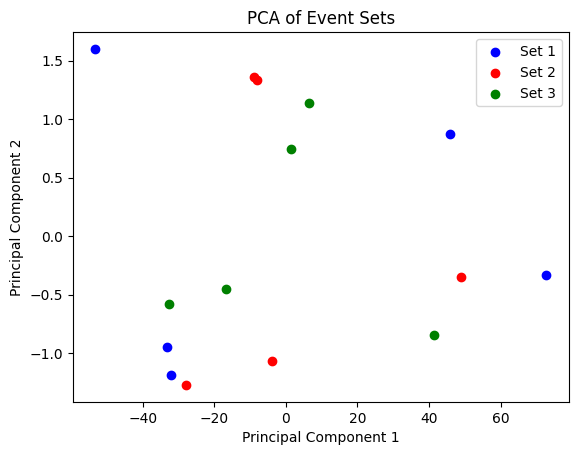

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
set1_pca = pca.fit_transform(set1)
set2_pca = pca.fit_transform(set2)
set3_pca = pca.fit_transform(set3)

plt.scatter(set1_pca[:, 0], set1_pca[:, 1], color='blue', label='Set 1')
plt.scatter(set2_pca[:, 0], set2_pca[:, 1], color='red', label='Set 2')
plt.scatter(set3_pca[:, 0], set3_pca[:, 1], color='green', label='Set 3')
plt.legend()
plt.title('PCA of Event Sets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
combined_data = pd.concat([set1.assign(source='set1'), set2.assign(source='set2')], ignore_index=True)

# Идентифицируем и удалим дубликаты
combined_data_unique = combined_data.drop_duplicates(subset=set1.columns[1:].tolist(), keep='first')

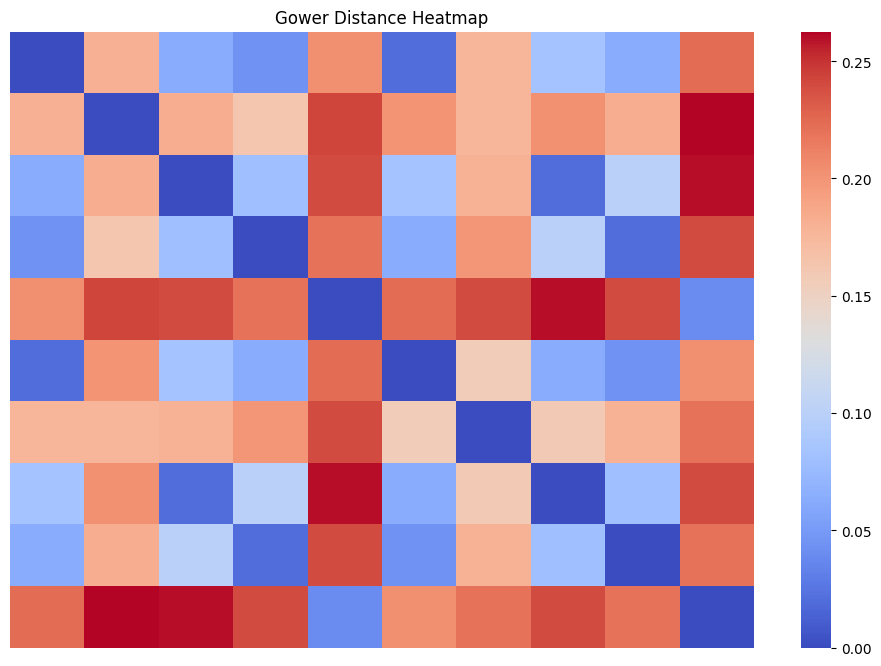

In [ ]:
import seaborn as sns
gower_distances = gower.gower_matrix(combined_data)

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(gower_distances, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Gower Distance Heatmap')
plt.show()


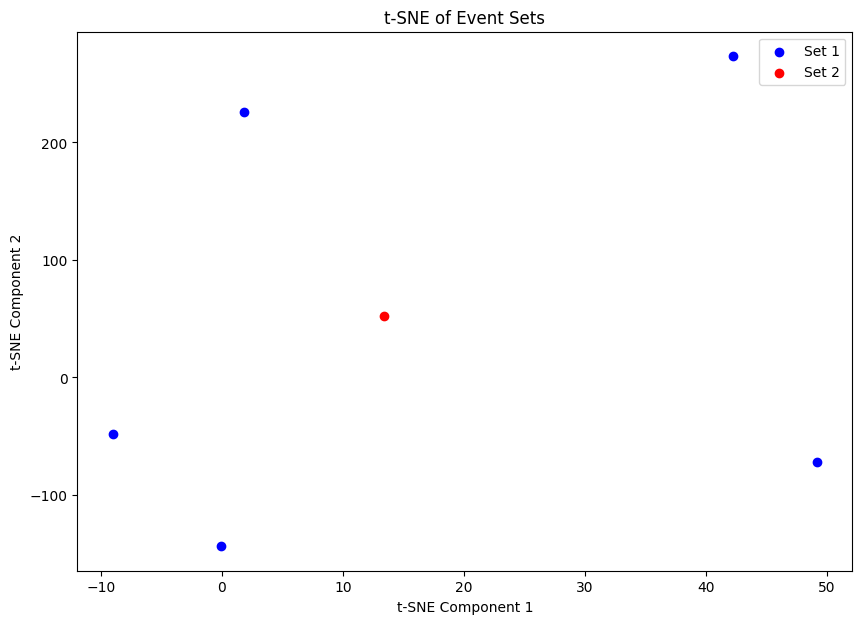

In [ ]:
from sklearn.manifold import TSNE

# Применим t-SNE для снижения размерности до 2 компонент
# tsne = TSNE(n_components=2, random_state=0, perplexity=2)
# tsne_result = tsne.fit_transform(combined_data_unique.iloc[:, :-1])

# Визуализация
tsne = TSNE(n_components=2, random_state=0, perplexity=2)
tsne_result = tsne.fit_transform(combined_data_unique.drop(columns=['source']))

plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[combined_data_unique['source'] == 'set1', 0], tsne_result[combined_data_unique['source'] == 'set1', 1], color='blue', label='Set 1')
plt.scatter(tsne_result[combined_data_unique['source'] == 'set2', 0], tsne_result[combined_data_unique['source'] == 'set2', 1], color='red', label='Set 2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Event Sets')
plt.legend()
plt.show()


In [ ]:
# Кластеризация с помощью KMeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x700 with 0 Axes>

# Оценка разнообразия

In [ ]:
# Функция для среднего расстояния внутри набора с использованием Gower's distance
def average_distance_within_set(events):
    distances = gower.gower_matrix(events)
    n = len(events)
    total_distance = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_distance += distances[i, j]
            count += 1
    return total_distance / count if count > 0 else 0

# Функция для среднего расстояния между наборами с использованием Gower's distance
def average_distance_between_sets(set1, set2):
    total_distance = 0
    count = 0
    for i in range(len(set1)):
        for j in range(len(set2)):
            total_distance += gower.gower_matrix(pd.DataFrame([set1.iloc[i]]), pd.DataFrame([set2.iloc[j]]))[0, 0]
            count += 1
    return total_distance / count if count > 0 else 0


within_set1 = average_distance_within_set(set1)
within_set2 = average_distance_within_set(set2)
within_set3 = average_distance_within_set(set3)
within_set4 = average_distance_within_set(set4)
within_set5 = average_distance_within_set(set5)
between_sets = average_distance_between_sets(set1, set3)

print(f"Average distance within set 1: {within_set1}")
print(f"Average distance within set 2: {within_set2}")
print(f"Average distance within set 3: {within_set3}")
print(f"Average distance within set 4: {within_set4}")
print(f"Average distance within set 5: {within_set5}")
print(f"Average distance between sets: {between_sets}")

Average distance within set 1: 0.17469387650489807
Average distance within set 2: 0.18775510117411615
Average distance within set 3: 0.14965986385941504
Average distance within set 4: 0.17555555655724472
Average distance within set 5: 0.15263794461886088
Average distance between sets: 0.16816326528787612


In [ ]:
# Кластеризация и индекс разнообразия
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def diversity_index(events, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(events)
    return silhouette_score(events, labels)

set1_diversity = diversity_index(set1)
set2_diversity = diversity_index(set2)
set3_diversity = diversity_index(set3)
set4_diversity = diversity_index(set4)
set5_diversity = diversity_index(set5)

print(f"Diversity index for set 1: {set1_diversity}")
print(f"Diversity index for set 2: {set2_diversity}")
print(f"Diversity index for set 3: {set3_diversity}")
print(f"Diversity index for set 4: {set4_diversity}")
print(f"Diversity index for set 5: {set5_diversity}")

Diversity index for set 1: 0.80186641957373
Diversity index for set 2: 0.6387499872039373
Diversity index for set 3: 0.4294593037340004
Diversity index for set 4: 0.6887691004408418
Diversity index for set 5: 0.6278335172998913


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Чем выше индекс силуэта, тем более схожи элементы внутри одного кластера и более различимы кластеры друг от друга. Высокий индекс силуэта указывает на то, что объекты внутри кластера расположены близко друг к другу и далеко от объектов других кластеров.

In [ ]:
!pip install gower

In [ ]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import gower

def average_distance_within_set(events, disfunc):
    n = len(events)
    total_distance = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_distance += disfunc(events.iloc[i, 1:], events.iloc[j, 1:])
            count += 1
    return total_distance / count if count > 0 else 0

def average_distance_between_sets(set1, set2, disfunc):
    total_distance = 0
    count = 0
    for i in range(len(set1)):
        for j in range(len(set2)):
            total_distance += disfunc(set1.iloc[i, 1:], set2.iloc[j, 1:])
            count += 1
    return total_distance / count if count > 0 else 0

func = cosine
within_set1 = average_distance_within_set(set1, func)
within_set2 = average_distance_within_set(set2, func)
within_set3 = average_distance_within_set(set3, func)
within_set4 = average_distance_within_set(set4, func)
within_set5 = average_distance_within_set(set5, func)
between_sets12 = average_distance_between_sets(set1, set2, func)
between_sets23 = average_distance_between_sets(set2, set3, func)
between_sets13 = average_distance_between_sets(set1, set3, func)

print(f"Average distance within set 1: {within_set1}")
print(f"Average distance within set 2: {within_set2}")
print(f"Average distance within set 3: {within_set3}")
print(f"Average distance within set 4: {within_set4}")
print(f"Average distance within set 5: {within_set5}")
print(f"Average distance between sets 1 & 3: {between_sets13}")
print(f"Average distance between sets 1 & 2: {between_sets12}")
print(f"Average distance between sets 2 & 3: {between_sets23}")

Average distance within set 1: 0.7202882064912757
Average distance within set 2: 0.8651463838788963
Average distance within set 3: 0.9568282222429616
Average distance within set 4: 0.8701741991080657
Average distance within set 5: 0.8801571257648952
Average distance between sets 1 & 3: 0.8778568685248871
Average distance between sets 1 & 2: 0.7117297455506534
Average distance between sets 2 & 3: 0.8574231889479513


Косинусное расстояние измеряет угол между двумя векторами.

Значение расстояния близкое к 1 указывает на малую схожесть, близкое к 0 указывает на высокую схожесть.

Average Distance Within Set (Среднее расстояние внутри набора):
Euclidean
**Высокое значение**: Указывает на то, что объекты внутри набора данных очень различаются. Это означает высокое разнообразие внутри набора.
**Низкое значение**: Указывает на то, что объекты внутри набора данных очень схожи. Это означает низкое разнообразие внутри набора.
Average Distance Between Sets (Среднее расстояние между наборами):

**Высокое значение**: Указывает на то, что объекты из одного набора данных сильно отличаются от объектов из другого набора данных. Это означает, что два набора данных имеют значительные различия.
**Низкое значение**: Указывает на то, что объекты из одного набора данных схожи с объектами из другого набора данных. Это означает, что два набора данных имеют низкие различия.